# INFO-F-422 - Projet

### R. Aerts 
### Rayane Tfeili 
### A. Laloy 

## Introduction

As part of the classe INFOF422. We carried out a project with the objective of predicting 51 hand joint angles from 8 surface EMG (sEMG) signals.
To tackle this task, we explored several regression models presented during the course, including Ridge Regression, Decision Trees, Random Forests, and Neural Networks. 




## Dataset preparation and augmentation through overlapping windows

Fourteen healthy volunteers participated in a protocol designed by the Machine Learning group.
However, this project uses data from only one participant, including raw sEMG signals and the corresponding hand poses for this individual.
Each participant performed two types of exercises:

***Guided gestures (guided)***: They repeated five predefined hand postures: a resting "open hand" posture and four single-finger extension gestures. A VR interface displayed each target gesture and provided feedback when it was recognized. Each session included multiple repetitions of the five poses.

**Free gestures (freemoves)**: Participants interacted naturally with various virtual 3D objects (e.g., hammers, keyboards, cups, rings) in six distinct VR scenes, a blank scene plus five interactive scenes eliciting a wide range of realistic hand and finger movements.

In total, participants completed 5 guided and free sessions, each lasting approximately 5 minutes.


The **guided gestures dataset** contains continuous sEMG signals (8 electrodes) as well as the corresponding estimated hand pose (51 joint angles) over 5 sessions during which the participant performed multiple repetitions of five predefined hand postures.

Specifically, the guided gestures dataset is composed of the following files:

- `guided_dataset_X.npy` : contains the training/validation data as a Numpy array of shape `(5, 8, 230000)` for (session, electrode, time)
- `guided_dataset_y.npy` : contains the estimation of the corresponding hand pose (the target to predict) as a Numpy array of shape `(5, 51, 230000)`
- `guided_testset_X.npy` : contains the training/validation data as a Numpy array of shape `(5, 332, 8, 500)` pour (session, window, electrode, time). For the competition, you must predict the estimated hand pose (51 values) for each window (i.e., **5 × 332 predictions** of 51 values in total).

The **free gestures dataset** contains continuous sEMG signals (8 electrodes) as well as the corresponding estimated hand pose (51 joint angles) over 5 sessions during which the participant freely performed a wide range of realistic hand and finger movements.

Specifically, the free gestures dataset is composed of the following files :

- `freemoves_dataset_X.npy` : contains the training/validation data as a Numpy array of shapeforme `(5, 8, 270000)` for (session, electrode, time)
- `freemoves_dataset_y.npy` :contains the corresponding estimated hand pose (the target to predict) as a Numpy array of shape`(5, 51, 270000)`
- `freemoves_testset_X.npy` : contains the test data as a Numpy array of shape `(5, 308, 8, 500)` pour (session, window, electrode, time). For the competition, you must predict the estimated hand pose (51 values) for each window (i.e., **5 × 308** predictions of 51 values in total).

When we examine the **free gestures dataset**, we will analyze the differences between the two datasets.

First, let's import the various files we need and store them in variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Importation of the files

# file freemoves
freemoves_dataset_X = np.load('F422 EMG project data/freemoves/freemoves_dataset_X.npy')
freemoves_dataset_y = np.load('F422 EMG project data/freemoves/freemoves_dataset_y.npy')
freemoves_testset_X = np.load('F422 EMG project data/freemoves/freemoves_testset_X.npy')

# file guided
guided_dataset_X = np.load('F422 EMG project data/guided/guided_dataset_X.npy')
guided_dataset_y = np.load('F422 EMG project data/guided/guided_dataset_y.npy')
guided_testset_X = np.load('F422 EMG project data/guided/guided_testset_X.npy')


We also import all the necessary modules.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import torch
import torch.nn as nn
import torch.optim as optim 
import pandas as pd
import random

C:\Users\Admin\anaconda3\envs\sfml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we will focus on the **guided gestures dataset**, which will likely yield better results due to the repetitiveness of the 5 movements.

In a second step, we will repeat our entire analysis on the **free gestures dataset**.

## Guided geasture datased

### Visualization

First, let's visualize what our different data look like.

We'll create a function that allows us to display the first 9.77 seconds of our first electrode during the first session (with selectable session and electrode), as well as the values of one hand joint angle for the same session and time frame (with selectable angle and time range).

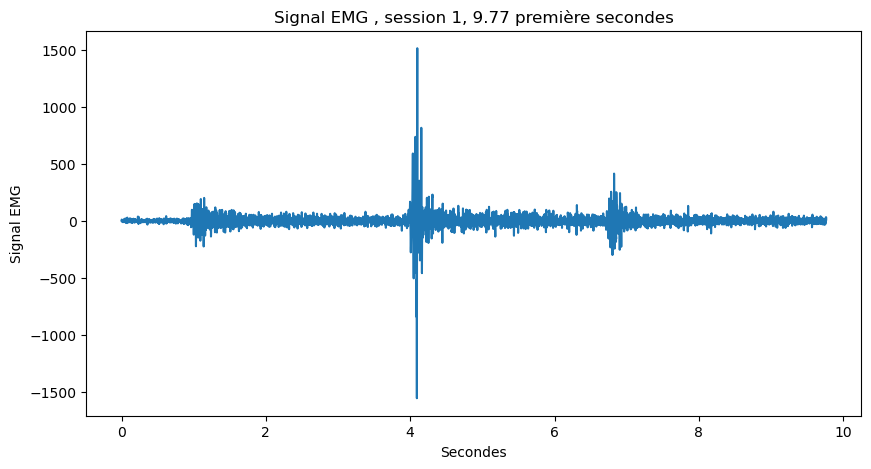

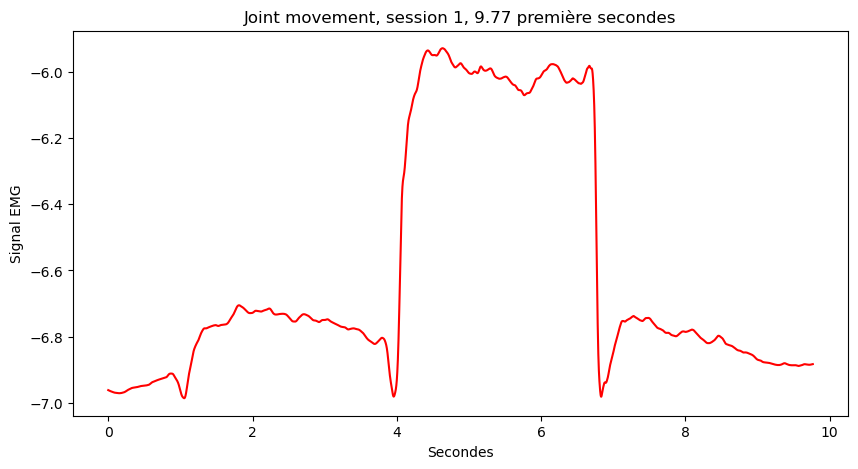

In [3]:
def Graphe_Emg_vs_JointAngle_Guided(session,electrode,joint_angle,time):
    
    X,y = guided_dataset_X,guided_dataset_y

    signal_emg = X[session,electrode, :time]
    joint_movement = y[session,joint_angle,:time]
    hz = 1024
    temps_sec = time/hz
    x = np.linspace(0,temps_sec,time)
    plt.figure(figsize=(10,5))
    plt.plot(x,signal_emg)
    plt.title(f"Signal EMG , session {session+1}, {temps_sec:.2f} première secondes")
    plt.xlabel("Secondes")
    plt.ylabel("Signal EMG")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(x,joint_movement,color="red")
    plt.title(f"Joint movement, session {session+1}, {temps_sec:.2f} première secondes")
    plt.xlabel("Secondes")
    plt.ylabel("Signal EMG")
    plt.show()

Graphe_Emg_vs_JointAngle_Guided(0,0,10,10000)

We observe that a peak in EMG signal activity is correlated with a change in the hand joint angle value. Using regression models to capture the dependency of hand position on the received signals is therefore a very reasonable approach, given the plots.

### Creating the windows

We will now create 2 functions that will allow us to create our windows with a specified **overlapping** (0.5 by default).
This will allow us to base our estimations of y at time t on the full set of signals from the 8 electrodes during the time interval [t−h, t], where h = **window_size** is the size of our windows.

This also removes one dimension, as we merge the sessions to obtain a single sequence of windows (4595 windows in the end for guided, for example).

It is important to note that there will be no **data leakage** when using K-fold for the cross-validation strategy, as we will take K = 5 = number of sessions, and the split will be done without shuffle.
So, since there is no **overlapping** between our different sessions (thanks to the for **loop that separates sessions**), we won’t have any **data leakage**.

Quick explanation:

1)We calculate the number of observations that will shift per window.

2)We start a **for loop** for each session and calculate the number of windows that will be created for that session (which is constant in our case).

3)Within each session, we run a **for loop** to create the windows.

4)We append each window to a list so that we end up with a single large session containing all the windows in chronological order.

In [4]:
def X_data_preparation(X, window_size = 500 ,overlap=0.5):
   
    step_window = int(window_size*(1-overlap))
    windows = []
    for session in range(X.shape[0]):
        nb_window = int((X.shape[2] - window_size)//step_window + 1 )
        for i in range(nb_window):
            compteur = i * step_window
            end = compteur + window_size 
            window = X[session, :, compteur:end]
            windows.append(window)
    return np.array(windows)

def y_data_preparation(Y , window_size = 500 , overlap=0.5):
      
    y_reg = []
    step_window = int(window_size*(1-overlap))
    for session in range(Y.shape[0]):
        nb_window = int((Y.shape[2] - window_size)//step_window + 1 )
        for i in range(nb_window):
            y_reg.append(Y[session,:, i* step_window + window_size -1])
    
    return np.array(y_reg)

a= X_data_preparation(guided_dataset_X,window_size = 500,overlap = 0.5)
b= y_data_preparation(guided_dataset_y,window_size = 500,overlap = 0.5)

print(np.shape(a))
print(np.shape(b))

(4595, 8, 500)
(4595, 51)


The shapes of our windowed data vectors indicate that we have 4595 windows for X and also 4595 windows for y.

### Cross-validation strategy: 

We opted for **5-fold cross-validation** for the following reasons:

1)It is much more effective than a simple split since each data point is reused multiple times while maintaining a separation between **training** and **test**. This results in a better estimation and less variance compared to a **hold-out approach**.

2)It is far less computationally expensive than a **leave-one-out**, which, while potentially more accurate, would take far too long to compute given the size of our data.

3)And perhaps the strongest argument is the ease of implementation! Since we create windows for each session, we must be very careful about **data leakage**. However, as explained during window construction, sessions are split independently and with K = 5, we ensure that no data points appear in multiple folds.

In [5]:
def k_fold_cross_validation (X,k):
    n = X.shape[0]
    step = n/k
    index = list(range(n))
    k_group = []
    for i in range(k):
        temp =  []
        val_index = [j for j in range(int(i*step),int((i+1)*step))]
        train_index = [l for l in index if l not in val_index]
        temp.append(train_index)
        temp.append(val_index)
        k_group.append(temp)
    return (k_group)

We will now compare our result with the KFold.split() function from the sklearn.model_selection library.sklearn.model_selection. Let’s perform a 5-fold on a list containing the integers from 0 to 99, noted as`liste_test` and check if we obtain the same partitions.

In [6]:
from sklearn.model_selection import KFold 

liste_test = np.array(list(range(100)))
v1 = k_fold_cross_validation (liste_test,5)
kf = KFold(n_splits=5, shuffle=False)
i = 0
for train_id, val_id in kf.split(liste_test):
    print(list(liste_test[train_id]) == v1[i][0])
    print(list(liste_test[val_id]) == v1[i][1])
    i += 1

True
True
True
True
True
True
True
True
True
True


Since the methods are similar, in the remainder of this report, we will use the KFold.split() function from the sklearn.model_selection library.

###  Baseline approach:

#### Set of features

Here is our **class Transformer** (that we took from the exercice and adapted), which will allow us to work with **features** extracted from our x data rather than working directly with the raw x data. By doing so, we further reduce the size of our data: instead of working with windows that are 500x8 matrices (500 time points per window and 8 electrodes), we work with a list of size number_of_features×8, which in our case will be 72 since we chose 9 **features**.

We use the **feature**s presented in the course, to which we add the median (MED), the Waveform Length (WL), and the Willison Amplitude (WAMP).

1)**Median**: captures the average muscle intensity while being robust to noise (which is very frequent in EMG).

2)**Waveform Length**: indicates a measure of waveform amplitude, frequency, and duration. Useful for capturing fast movements and jerks.

3)**Willison Amplitude**: computes intensity/activity beyond a certain threshold. By using quantiles to determine the threshold, we make this **feature** more robust to potential noise. This feature thus captures sudden changes that can be interpreted as movement triggers.

In [7]:
class Transformer(BaseEstimator, TransformerMixin):

    def __init__(self, constant=0.0):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = []
        for window in X:
            features_per_window = []
            for electrode in window:
                features_per_window.append(np.mean(np.abs(electrode))) # MAV
                features_per_window.append(np.sqrt(np.mean(electrode**2))) # RMS
                features_per_window.append(np.var(electrode)) # VAR
                features_per_window.append(np.std(electrode))# STD
                features_per_window.append(np.sum((electrode[:-1] * electrode[1:] < 0))) #ZERO CROSSING
                var = np.std(electrode)
                MPR_vec = np.abs(electrode) > var
                features_per_window.append(np.mean(MPR_vec)) #MPR
                features_per_window.append(np.median(electrode)) # MED
                features_per_window.append(np.sum(np.diff(electrode))) ## Waveform Length (WL)
                T = np.percentile(np.abs(electrode), 75)
                features_per_window.append(np.sum(np.abs(np.diff(electrode)) > T)) #WAMP
                
            features.append(features_per_window)
        return np.array(features)



And there we go! Now we can apply the *transform* attribute to our data to extract our **features**.

#### Data formatting

Our **inputs** being the same for all our regression models, we format our data only once here so that we can then directly feed what we’ll call **X_reg** and **y_reg** into our regression models.

Here's what happens in detail:

1) We start by applying our preprocessing functions to X and y so that we end up with a single sequence of windows, as previously explained.

2) Then, we call our **class Transformer**, which converts each X window into our selected **features**, and this is done for each electrode, as the relevance and usefulness of our **features** (for predicting y) may vary depending on the electrode.

3) In the end, we obtain a matrix of shape (4595, 72) for X and (4595, 51) for y, where 4595 is the number of windows, 72 is the number of **features** (9 multiplied by the number of electrodes), and 51 are the different values to be predicted for the hand pose (see introduction).

In [8]:
X = guided_dataset_X  
y = guided_dataset_y
transformer= Transformer()
window_X_guided = X_data_preparation(X, window_size = 500,overlap = 0.5)
X_reg_guided = Transformer().transform(window_X_guided)
y_reg_guided = y_data_preparation(y,window_size = 500,overlap = 0.5)
print(X_reg_guided.shape)
print(y_reg_guided.shape)

feature_names = ["MAV", "RMS", "VAR", "STD", "ZC" ,"MPR", "MED", "WL","WAMP"]  
feature_names_electrode = [f"{feature}_elect{electrode+1}" for electrode in range(8) for feature in feature_names]

(4595, 72)
(4595, 51)


####  Preliminary PCA

Still with the goal of reducing the size of our data, we perform a **PCA** on our **features**, as many of them are highly correlated. Another advantage of **PCA** is its ability to reduce noise, since noise often has low variance (in any case, lower than that of the actual muscle signals).

The drawback of **PCA** is that we lose interpretability, as the components are linear combinations of our original **features**. Additionally, some of our regression models that are not sensitive to feature correlation (such as a **Neural Network**) will not use the preliminary **PCA**.

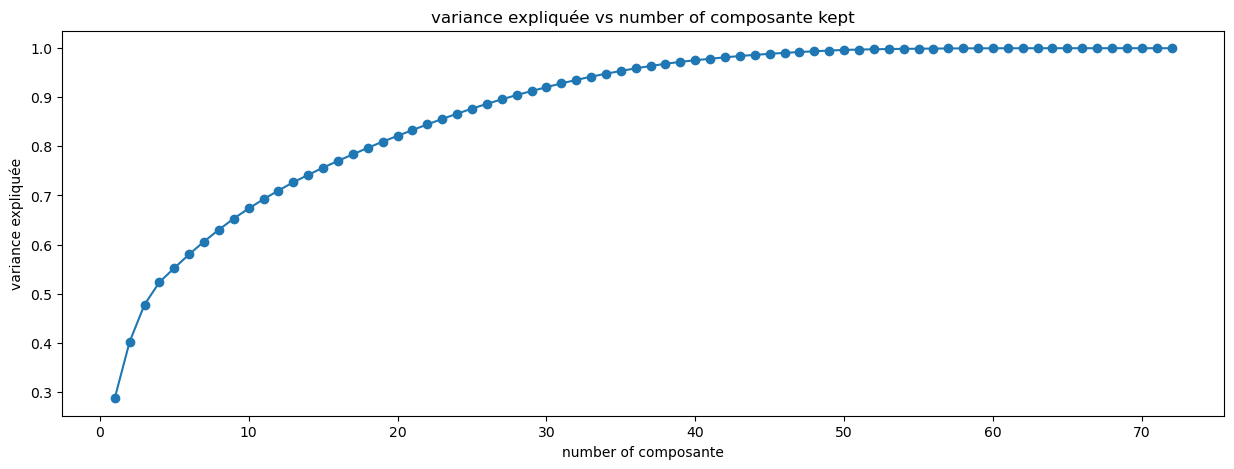

In [9]:
pca_guided = PCA()
scaler_guided = StandardScaler()
pca_guided.fit(scaler_guided.fit_transform(X_reg_guided))

plt.figure(figsize=(15,5))
plt.plot([i for i in range(1,len(pca_guided.explained_variance_ratio_)+1)], np.cumsum(pca_guided.explained_variance_ratio_), marker='o')
plt.title("explained variance vs number of composante kept")
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.show()

In [10]:
print(np.sum(pca_guided.explained_variance_ratio_[:46]))
nb_composante_keep_guided = 46

0.9905401291195872


A calculation of the cumulative explained variance shows that to reach the 99% threshold, we need to keep the first 46 principal components!

Here, we modify our dataset to include our 46 principal components, ready to be fed into our regression models.

In [11]:
n = X_reg_guided.shape[1] # nombre de composante à garder (ajustable)
pca_guided = PCA(n_components = nb_composante_keep_guided)
X_reg_pca_guided = pca_guided.fit_transform(X_reg_guided)
principal_componant_guided = [f"composante principale_{i+1}" for i in range(nb_composante_keep_guided)]

Below, we will create a function that allows us to project a new dataset onto the space spanned by the 46 principal components.

#### Random Forest

Here is our first regression model ; a Random Forest, we will compute the **RMSE**, the **NMSE** and the **feature importances**


We chose to implement our cross-validation using a K-Fold with 5 splits. This effectively performs a **Leave One Session Out strategy**.

Indeed, at each iteration of the loop, we train on 4 out of the 5 sessions and validate on the remaining one. This method helps to minimize overfitting of our model.

Regarding the **feature importance**, at each fold, we compute the feature importance associated with the specific training of our model using the **.feature_importances_** attribute of the **RandomForestRegressor class**, which calculates the relative importance of our **feature**s. Once the loop is complete, we take the **average feature importance** across folds, component by component, to obtain a **final feature importance vector**, which we will plot to get an idea of the importance of our features (which are now principal components from our PCA).

Important note: we set *random_state* = 42 to ensure that our RMSE and NMSE comparisons are not affected by randomness (thus ensuring reproducibility).
As such, for the other regression models,we will also use *random_state = 42*.

The choice of *n = 100* for the number of trees in our **Random Forest** is a common one, and it also proved satisfactory in practice when we ran several experiments with different n values.

(46,)


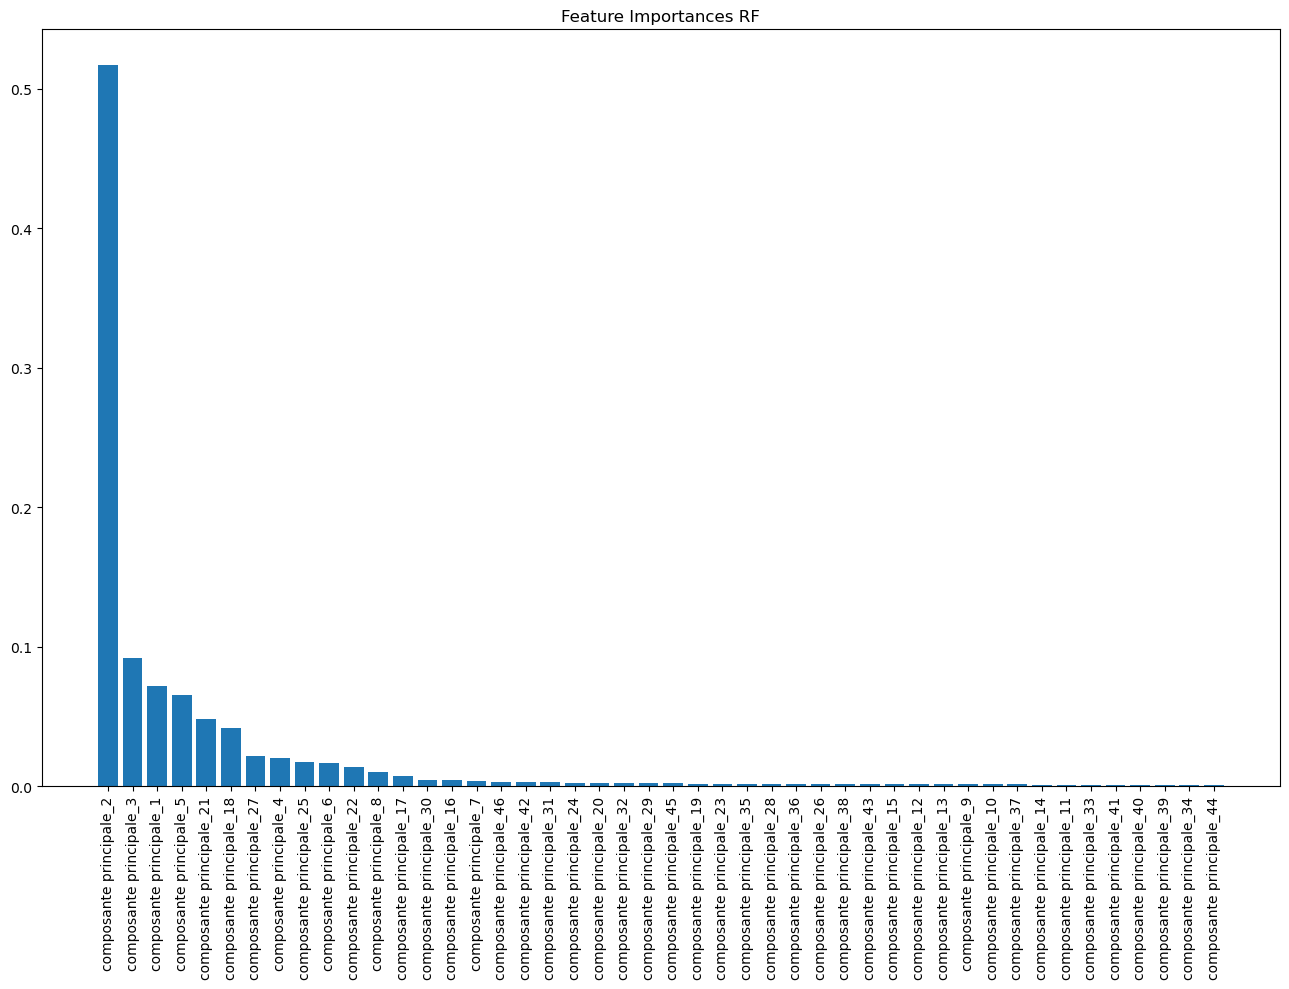

Pipeline (Random Forest) RMSE:  3.1704418198195405
Pipeline (Random Forest) NMSE:  0.061681604066945915


In [12]:
pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

kf = KFold(n_splits=5, shuffle=False)
rmse_score_rf = []
nmse_score_rf = []
liste_importance = []

for train_id, val_id in kf.split(X_reg_pca_guided):
    X_train, X_test = X_reg_pca_guided[train_id], X_reg_pca_guided[val_id]
    y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]

    pipeline_rf.fit(X_train, y_train)
    y_pred_pipe = pipeline_rf.predict(X_test)


    rmse_pipeline_rf = root_mean_squared_error(y_test, y_pred_pipe)
    mse_pipeline_rf  = mean_squared_error(y_test,y_pred_pipe)


    rmse_score_rf.append(rmse_pipeline_rf)
    nmse_score_rf.append(mse_pipeline_rf/np.var(y_test))
    
    
    #feature importance     
    importances = pipeline_rf.named_steps["regressor"].feature_importances_
    liste_importance.append(importances)


importances_final = np.mean( liste_importance, axis=0)
indices = np.argsort(importances_final)[::-1]
print(importances_final.shape)
plt.figure(figsize=(13,10))
plt.title("Feature Importances RF")
plt.bar(range(len(importances_final)), importances_final[indices], align='center')
plt.xticks(range(len(importances_final)), [principal_componant_guided[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


print("Pipeline (Random Forest) RMSE: ",np.mean(rmse_score_rf))
print("Pipeline (Random Forest) NMSE: ",np.mean(nmse_score_rf))


And here are our first **RMSE and NMSE** results ! At this stage, it's not yet possible to compare them with those of other models so we'll do that later. As for the **feature importance**, the plot clearly shows a significant difference in the contribution of various features to the prediction of y.

However, we cannot simply select the top **n features** from the plot, as these do not necessarily **minimize the RMSE** (as required in the assignment instructions).
For **feature selection**, we intended to apply the method introduced during the lab session (and used for Ridge): the **Forward Wrapped Method**. This method iteratively tests the addition of each **feature** to the current set by evaluating the **model’s RMSE** at each step.

However, since a **Random Forest is a non-linear model** and takes time to train, applying the **forward wrapped method** requires training many **Random Forests**, making the **complexity exponential**.
As a result, our code took too long to run, so we decided not to include it.

#### Ridge regression

Here is our second regression model: **Ridge regression**.
The process is exactly the same as with our **Random Forest model** (we simply change the regression model within the pipeline).We will compute the **RMSE, the NMSE, and the feature importances**.

Let’s now discuss the choice of **alpha** for our **Ridge regression**.We will test several values of alpha and identify the one that **minimizes the RMSE**.

Pipeline (Random Forest) RMSE for alpha = 0.01:  4.342780867892122
Pipeline (Random Forest) NMSE:for alpha = 0.01:  0.12439952443986464
Pipeline (Random Forest) RMSE for alpha = 0.1:  4.342770267209367
Pipeline (Random Forest) NMSE:for alpha = 0.1:  0.12439891966417951
Pipeline (Random Forest) RMSE for alpha = 1:  4.342664734233007
Pipeline (Random Forest) NMSE:for alpha = 1:  0.1243928999971109
Pipeline (Random Forest) RMSE for alpha = 10:  4.341656522602972
Pipeline (Random Forest) NMSE:for alpha = 10:  0.12433549566388617
Pipeline (Random Forest) RMSE for alpha = 50:  4.338183242432927
Pipeline (Random Forest) NMSE:for alpha = 50:  0.12414000403365329
Pipeline (Random Forest) RMSE for alpha = 100:  4.336028299166609
Pipeline (Random Forest) NMSE:for alpha = 100:  0.12402479482788768
Pipeline (Random Forest) RMSE for alpha = 150:  4.3361138428881985
Pipeline (Random Forest) NMSE:for alpha = 150:  0.12404168926801962
Pipeline (Random Forest) RMSE for alpha = 200:  4.33825055667653
Pip

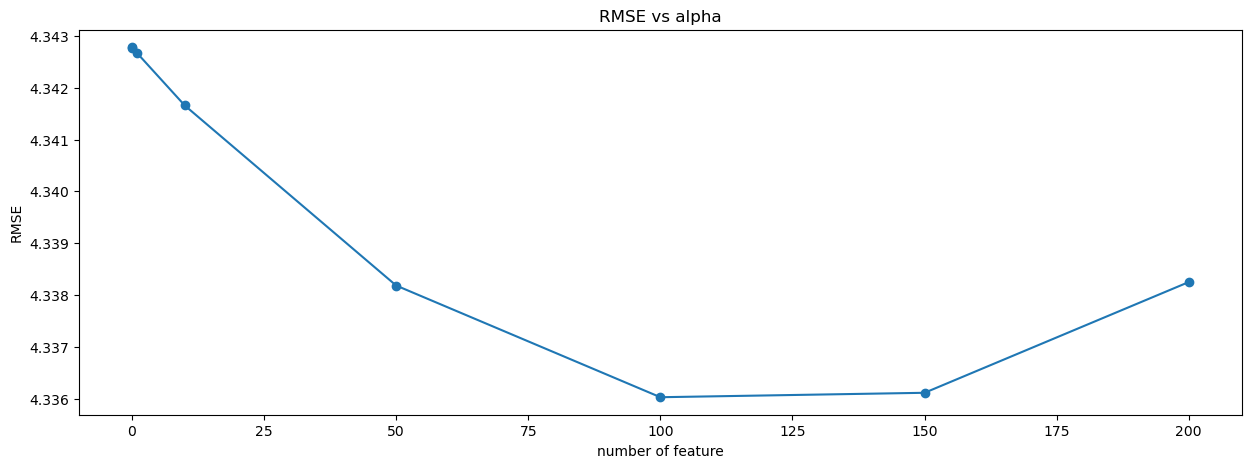

In [13]:
different_alpha = [0.01, 0.1, 1, 10, 50, 100, 150, 200]
rmse_alpha_ridge = []
for alpha in different_alpha:
    pipeline_ridge = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", Ridge(alpha = alpha, random_state=42))
    ])
    kf = KFold(n_splits=5, shuffle=False)
    rmse_score_ridge = []
    nmse_score_ridge = []
    liste_importance = []

    for train_id, val_id in kf.split(X_reg_pca_guided):
        X_train, X_test =  X_reg_pca_guided[train_id],  X_reg_pca_guided[val_id]
        y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]

        pipeline_ridge.fit(X_train, y_train)
        y_pred_pipe = pipeline_ridge.predict(X_test)


        rmse_pipeline_ridge = root_mean_squared_error(y_test, y_pred_pipe)
        mse_pipeline_ridge  = mean_squared_error(y_test,y_pred_pipe)


        rmse_score_ridge.append(rmse_pipeline_ridge)
        nmse_score_ridge.append(mse_pipeline_ridge/np.var(y_test))

        
    rmse_alpha_ridge.append(np.mean(rmse_score_ridge))
    print(f"Pipeline (Random Forest) RMSE for alpha = {alpha}: ",np.mean(rmse_score_ridge))
    print(f"Pipeline (Random Forest) NMSE:for alpha = {alpha}: ",np.mean(nmse_score_ridge))

    
plt.figure(figsize=(15,5))
plt.plot(different_alpha,rmse_alpha_ridge, marker='o')
plt.title("RMSE vs alpha")
plt.xlabel("number of feature")
plt.ylabel("RMSE")
plt.show()

We observe that all **RMSE** values are very similar regardless of the choice of **alpha** (ranging between 4.33 and 4.34).Therefore, the choice of **alpha** has little impact on the performance of our model.
In the following, we will choose **alpha = 100** (which still yields the lowest RMSE).

(46,)
(46,)


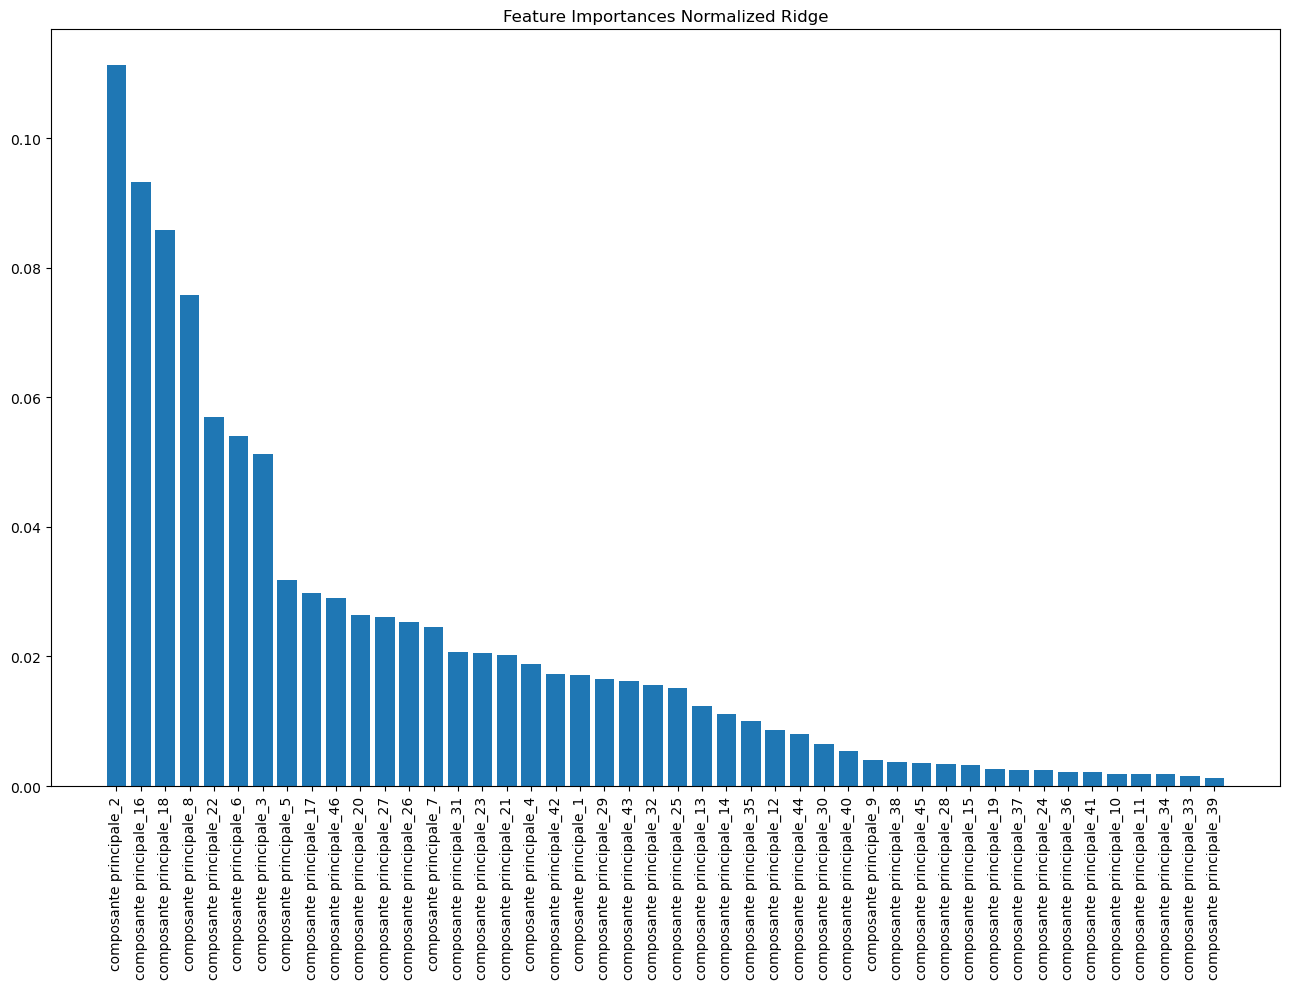

Pipeline (Random Forest) RMSE:  4.336028299166609
Pipeline (Random Forest) NMSE:  0.12402479482788768


In [14]:
pipeline_ridge_guided = Pipeline([
("imputer", SimpleImputer(strategy="mean")),
("scaler", StandardScaler()),
("regressor", Ridge(alpha = 100, random_state=42))
])
kf = KFold(n_splits=5, shuffle=False)
rmse_score_ridge = []
nmse_score_ridge = []
liste_importance = []

for train_id, val_id in kf.split(X_reg_pca_guided):
    X_train, X_test =  X_reg_pca_guided[train_id],  X_reg_pca_guided[val_id]
    y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]

    pipeline_ridge_guided.fit(X_train, y_train)
    y_pred_pipe = pipeline_ridge_guided.predict(X_test)


    rmse_pipeline_ridge = root_mean_squared_error(y_test, y_pred_pipe)
    mse_pipeline_ridge  = mean_squared_error(y_test,y_pred_pipe)


    rmse_score_ridge.append(rmse_pipeline_ridge)
    nmse_score_ridge.append(mse_pipeline_ridge/np.var(y_test))
    
    
    #feature importance     
    importances = pipeline_ridge_guided.named_steps["regressor"].coef_
    liste_importance.append(np.abs(importances[1]))


importances_final = np.mean( liste_importance, axis=0)
importances_final = importances_final / importances_final.sum()
indices = np.argsort(importances_final)[::-1]
print(importances_final.shape)
print(indices.shape)
plt.figure(figsize=(13,10))
plt.title("Feature Importances Normalized Ridge")
plt.bar(range(len(importances_final)), importances_final[indices], align='center')
plt.xticks(range(len(importances_final)), [principal_componant_guided[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


print("Pipeline (Random Forest) RMSE: ",np.mean(rmse_score_ridge))
print("Pipeline (Random Forest) NMSE: ",np.mean(nmse_score_ridge))

Now that we have these results, we can compare them with our Random Forest.In terms of computation time, there’s no contest: **Ridge** runs in about **1 second**, while our **Random Forest** takes approximately **400 seconds**.
However, the **NMSE for Ridge is twice as high, and the RMSE is about 25% higher**.
Thus, our **Random Forest performs better**  and this makes sense intuitively, as predicting hand movements from EMG signals involves many non-linear dependencies !

We will now perform feature selection for the **Ridge** regression model using the forward wrapped method function introduced in TP5.

In [15]:
selected_ridge = []
n_features_to_select = 46# ajustable
n_features =  X_reg_pca_guided.shape[1]
 

kf = KFold(n_splits=5, shuffle=False)
cv_error_list_ridge = []

for round_i in range(n_features_to_select):
    candidates = list(set(range(n_features)) - set(selected_ridge))
    cv_errors = []

    for c in candidates:
        features_to_include = selected_ridge + [c]
        fold_errors = []

        for train_index, test_index in kf.split( X_reg_pca_guided):
            X_train =  X_reg_pca_guided[train_index][:, features_to_include]
            X_test =  X_reg_pca_guided[test_index][:, features_to_include]
            y_train, y_test = y_reg_guided[train_index], y_reg_guided[test_index]

            model = Pipeline([("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler()),
                ("regressor", Ridge(alpha=100))
            ])
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_errors.append(root_mean_squared_error(y_test, y_pred))

        cv_errors.append(np.mean(fold_errors))

    best_candidate = candidates[np.argmin(cv_errors)]
    cv_error_list_ridge.append(round(min(cv_errors),4))
    selected_ridge.append(best_candidate)
    print("Round", round_i+1, "; Selected feature:", best_candidate,
          "; CV RMSE=", round(min(cv_errors),4))
        
        
print(" Final selected feature indices:", selected_ridge)
for number in selected_ridge:
    component = principal_componant_guided[number]
    print(component)

Round 1 ; Selected feature: 17 ; CV RMSE= 7.2364
Round 2 ; Selected feature: 15 ; CV RMSE= 6.7877
Round 3 ; Selected feature: 1 ; CV RMSE= 6.2881
Round 4 ; Selected feature: 3 ; CV RMSE= 6.0851
Round 5 ; Selected feature: 2 ; CV RMSE= 5.9026
Round 6 ; Selected feature: 20 ; CV RMSE= 5.7489
Round 7 ; Selected feature: 7 ; CV RMSE= 5.5933
Round 8 ; Selected feature: 4 ; CV RMSE= 5.4409
Round 9 ; Selected feature: 24 ; CV RMSE= 5.2814
Round 10 ; Selected feature: 5 ; CV RMSE= 5.1321
Round 11 ; Selected feature: 19 ; CV RMSE= 5.0296
Round 12 ; Selected feature: 26 ; CV RMSE= 4.9273
Round 13 ; Selected feature: 22 ; CV RMSE= 4.8453
Round 14 ; Selected feature: 21 ; CV RMSE= 4.7697
Round 15 ; Selected feature: 0 ; CV RMSE= 4.6976
Round 16 ; Selected feature: 27 ; CV RMSE= 4.6507
Round 17 ; Selected feature: 28 ; CV RMSE= 4.6111
Round 18 ; Selected feature: 31 ; CV RMSE= 4.5718
Round 19 ; Selected feature: 25 ; CV RMSE= 4.5313
Round 20 ; Selected feature: 45 ; CV RMSE= 4.4914
Round 21 ; Selec

Let's plot the minimum RMSE as a function of the number of **selected features**.

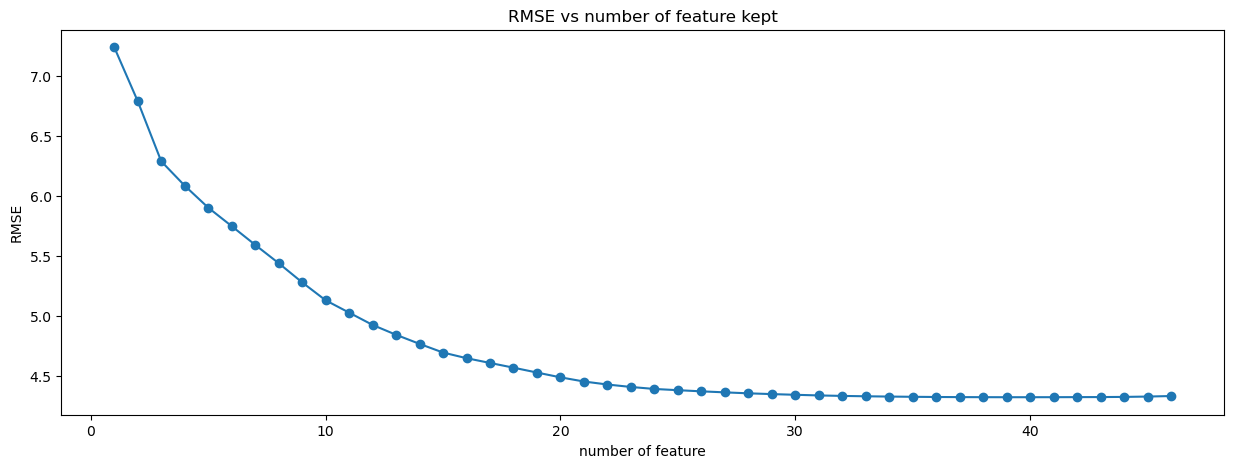

In [16]:
plt.figure(figsize=(15,5))
plt.plot([i for i in range(1,len(cv_error_list_ridge)+1)], cv_error_list_ridge, marker='o')
plt.title("RMSE vs number of feature kept")
plt.xlabel("number of feature")
plt.ylabel("RMSE")
plt.show()

By analyzing the graph above, we chose to select the first **39 features** during our feature selection process.

In [18]:
selected_ridge_guided = selected_ridge[:39]
print(f"after feature selection , our RMSE is {cv_error_list_ridge[38]}")

after feature selection , our RMSE is 4.3261


Explanation: we select the features that minimize the **RMSE**, n_features_to_select is the number of features we decide to keep in order to minimize the **RMSE**. Just above, you can find the **RMSE value when using 46 features** (i.e., all the features in our dataset).
We obtain the **lowest RMSE when selecting 39 features**, so we stop at **39 selected features**.

If we compare the **feature importance plot with the selected features**, we notice that they are not necessarily the same and that’s completely expected.
**Feature importance measures** the individual impact of a feature on the model,
while the **wrapped method used for feature selection** adds a feature if and only if it improves **RMSE**, meaning it takes into account combined effects among features.

#### Tree regression

Here is our third regression model: a **regression tree**.We follow the same procedure as before, computing the **RMSE**, **NMSE**, and **feature importances**.

First, we will determine the **optimal depth of the tree**.To do this, we will test several depths and keep the one that minimizes the **RMSE**.We will display this on a plot to make the interpretation clearer.

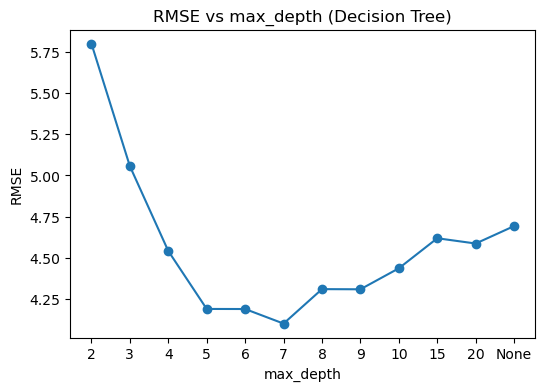

In [19]:
depths = [2, 3 , 4, 5, 6, 7, 8, 9, 10, 15, 20, None]
mse_values_tree = []
kf = KFold(n_splits=5, shuffle=False)

for d in depths:
    mse_values_cv = []
    pipeline_rt = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", DecisionTreeRegressor(max_depth=d,random_state=42))
    ])
    for train_id, val_id in kf.split( X_reg_pca_guided):
        X_train, X_test = X_reg_pca_guided[train_id],  X_reg_pca_guided[val_id]
        y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]

        pipeline_rt.fit(X_train, y_train)
        y_pred_pipe_rt = pipeline_rt.predict(X_test)
        
        mse_values_cv.append(root_mean_squared_error(y_test, y_pred_pipe_rt))
        
    mse_values_tree.append(np.mean(mse_values_cv))

plt.figure(figsize=(6,4))
plt.plot([str(d) for d in depths], mse_values_tree, marker='o')
plt.title("RMSE vs max_depth (Decision Tree)")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.show()

Here, we see that the **RMSE is lowest when the tree has a depth of 7**.We will therefore use this **depth of 7** in the following analyses.

Here we are computing the **feature importances** as before.

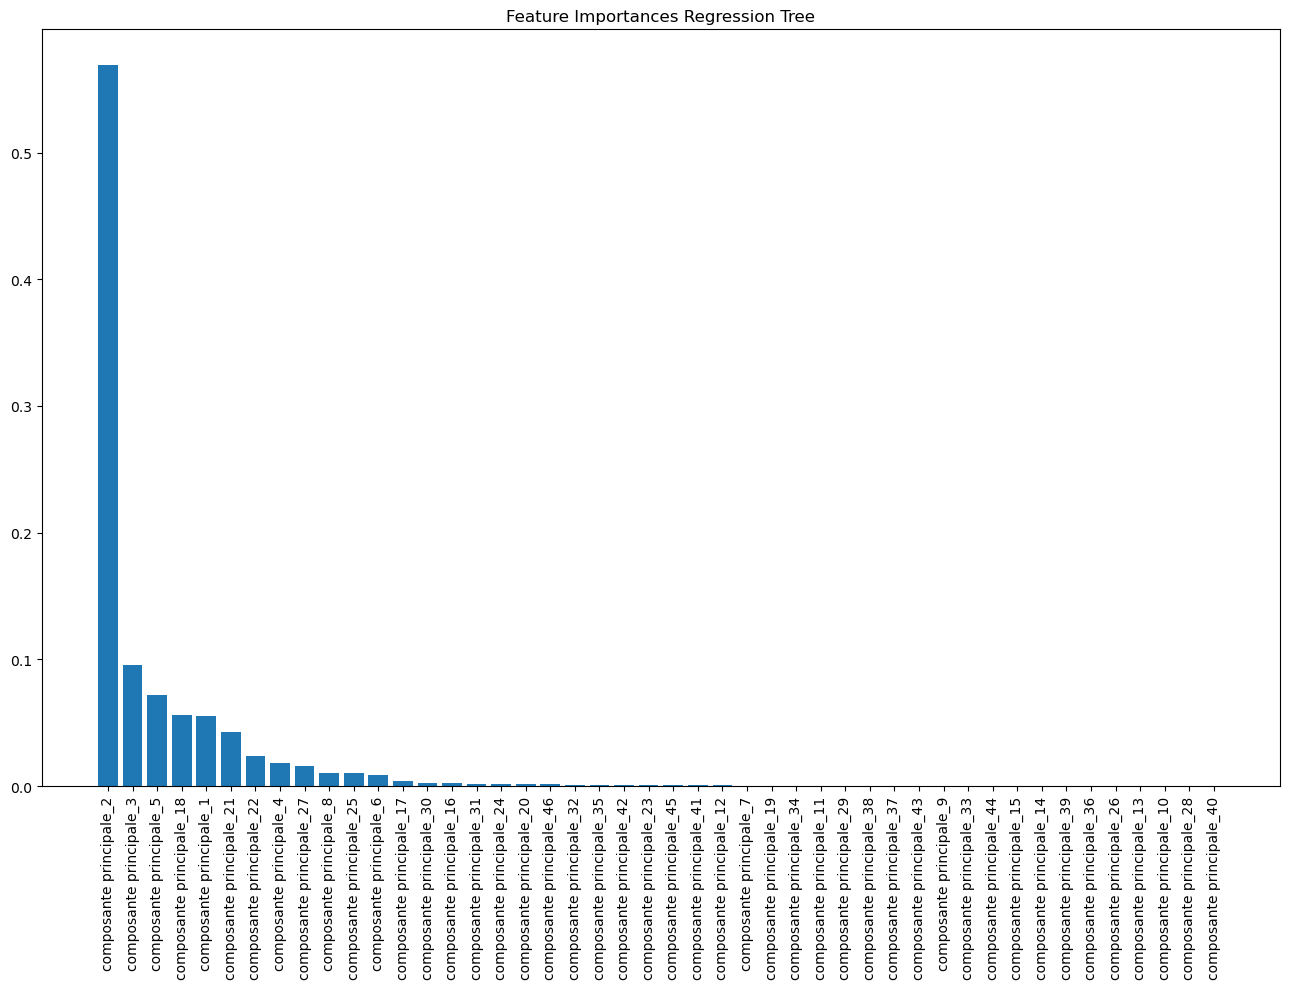

Pipeline (Regression Tree) RMSE:  4.100797657606738
Pipeline (Regression Tree) NMSE:  0.10780528230330888


In [20]:
pipeline_rt_guided = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", DecisionTreeRegressor(max_depth=7 , random_state=42)) ## We set the depth to 7, as obtained in the previous cell. 
])

kf = KFold(n_splits=5, shuffle=False)
rmse_score_rt = []
nmse_score_rt = []
liste_importance = []

for train_id, val_id in kf.split( X_reg_pca_guided):
    X_train, X_test =  X_reg_pca_guided[train_id],  X_reg_pca_guided[val_id]
    y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]

    pipeline_rt_guided.fit(X_train, y_train)
    y_pred_pipe = pipeline_rt_guided.predict(X_test)


    rmse_pipeline_rt = root_mean_squared_error(y_test, y_pred_pipe)
    mse_pipeline_rt  = mean_squared_error(y_test,y_pred_pipe)


    rmse_score_rt.append(rmse_pipeline_rt)
    nmse_score_rt.append(mse_pipeline_rt/np.var(y_test))
    
    
    #feature importance     
    importances = pipeline_rt_guided.named_steps["regressor"].feature_importances_
    liste_importance.append(importances)


importances_final = np.mean( liste_importance, axis=0)
indices = np.argsort(importances_final)[::-1]
plt.figure(figsize=(13,10))
plt.title("Feature Importances Regression Tree")
plt.bar(range(len(importances_final)), importances_final[indices], align='center')
plt.xticks(range(len(importances_final)), [principal_componant_guided[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

print("Pipeline (Regression Tree) RMSE: ",np.mean(rmse_score_rt))
print("Pipeline (Regression Tree) NMSE: ",np.mean(nmse_score_rt))

Our third result gives us an **RMSE and NMSE** slightly lower than those of **Ridge**, but clearly higher than those of our **Random Forest**.

Here, just like we did for **Ridge**, we perform **feature selection** for our **regression tree**.

In [21]:
selected_rt = []
n_features_to_select = 20 # ajustable
n_features =  X_reg_pca_guided.shape[1] 

kf = KFold(n_splits=5, shuffle=False)
cv_error_list_rt = []


for round_i in tqdm(range(n_features_to_select)):
    candidates = list(set(range(n_features)) - set(selected_rt))
    cv_errors = []

    for c in candidates:
        features_to_include = selected_rt + [c]
        fold_errors = []

        for train_index, test_index in kf.split( X_reg_pca_guided):
            X_train =  X_reg_pca_guided[train_index][:, features_to_include]
            X_test =  X_reg_pca_guided[test_index][:, features_to_include]
            y_train, y_test = y_reg_guided[train_index], y_reg_guided[test_index]

            pipeline_rt_guided.fit(X_train, y_train)
            y_pred = pipeline_rt_guided.predict(X_test)
            fold_errors.append(root_mean_squared_error(y_test, y_pred))

        cv_errors.append(np.mean(fold_errors))

    best_candidate = candidates[np.argmin(cv_errors)]
    cv_error_list_rt.append(round(min(cv_errors),4))
    selected_rt.append(best_candidate)
    print("Round", round_i+1, "; Selected feature:", best_candidate,
          "; CV RMSE=", round(min(cv_errors),4))
        
        
print(" Final selected feature indices:", selected_rt)
for number in selected_rt:
    component = principal_componant_guided[number]
    print(component)

  5%|▌         | 1/20 [00:03<01:09,  3.63s/it]

Round 1 ; Selected feature: 1 ; CV RMSE= 5.9104


 10%|█         | 2/20 [00:08<01:15,  4.22s/it]

Round 2 ; Selected feature: 2 ; CV RMSE= 5.0726


 15%|█▌        | 3/20 [00:13<01:22,  4.86s/it]

Round 3 ; Selected feature: 17 ; CV RMSE= 4.3372


 20%|██        | 4/20 [00:20<01:29,  5.59s/it]

Round 4 ; Selected feature: 24 ; CV RMSE= 4.1906


 25%|██▌       | 5/20 [00:28<01:35,  6.34s/it]

Round 5 ; Selected feature: 21 ; CV RMSE= 4.0451


 30%|███       | 6/20 [00:36<01:39,  7.09s/it]

Round 6 ; Selected feature: 4 ; CV RMSE= 4.0092


 35%|███▌      | 7/20 [00:46<01:42,  7.85s/it]

Round 7 ; Selected feature: 20 ; CV RMSE= 3.9258


 40%|████      | 8/20 [00:56<01:44,  8.73s/it]

Round 8 ; Selected feature: 0 ; CV RMSE= 3.9255


 45%|████▌     | 9/20 [01:07<01:44,  9.49s/it]

Round 9 ; Selected feature: 3 ; CV RMSE= 3.8087


 50%|█████     | 10/20 [01:19<01:42, 10.23s/it]

Round 10 ; Selected feature: 27 ; CV RMSE= 3.7757


 55%|█████▌    | 11/20 [01:32<01:37, 10.85s/it]

Round 11 ; Selected feature: 8 ; CV RMSE= 3.8919


 60%|██████    | 12/20 [01:45<01:32, 11.53s/it]

Round 12 ; Selected feature: 23 ; CV RMSE= 3.8273


 65%|██████▌   | 13/20 [01:58<01:24, 12.13s/it]

Round 13 ; Selected feature: 36 ; CV RMSE= 3.86


 70%|███████   | 14/20 [02:12<01:16, 12.70s/it]

Round 14 ; Selected feature: 37 ; CV RMSE= 3.8671


 75%|███████▌  | 15/20 [02:27<01:06, 13.25s/it]

Round 15 ; Selected feature: 42 ; CV RMSE= 3.8482


 80%|████████  | 16/20 [02:42<00:54, 13.70s/it]

Round 16 ; Selected feature: 15 ; CV RMSE= 3.9007


 85%|████████▌ | 17/20 [02:57<00:42, 14.13s/it]

Round 17 ; Selected feature: 25 ; CV RMSE= 3.942


 90%|█████████ | 18/20 [03:12<00:29, 14.51s/it]

Round 18 ; Selected feature: 9 ; CV RMSE= 3.8642


 95%|█████████▌| 19/20 [03:28<00:14, 14.83s/it]

Round 19 ; Selected feature: 45 ; CV RMSE= 3.8884


100%|██████████| 20/20 [03:44<00:00, 11.23s/it]

Round 20 ; Selected feature: 35 ; CV RMSE= 3.8714
 Final selected feature indices: [1, 2, 17, 24, 21, 4, 20, 0, 3, 27, 8, 23, 36, 37, 42, 15, 25, 9, 45, 35]
composante principale_2
composante principale_3
composante principale_18
composante principale_25
composante principale_22
composante principale_5
composante principale_21
composante principale_1
composante principale_4
composante principale_28
composante principale_9
composante principale_24
composante principale_37
composante principale_38
composante principale_43
composante principale_16
composante principale_26
composante principale_10
composante principale_46
composante principale_36


Let’s now display this in a plot to get a better visualization.

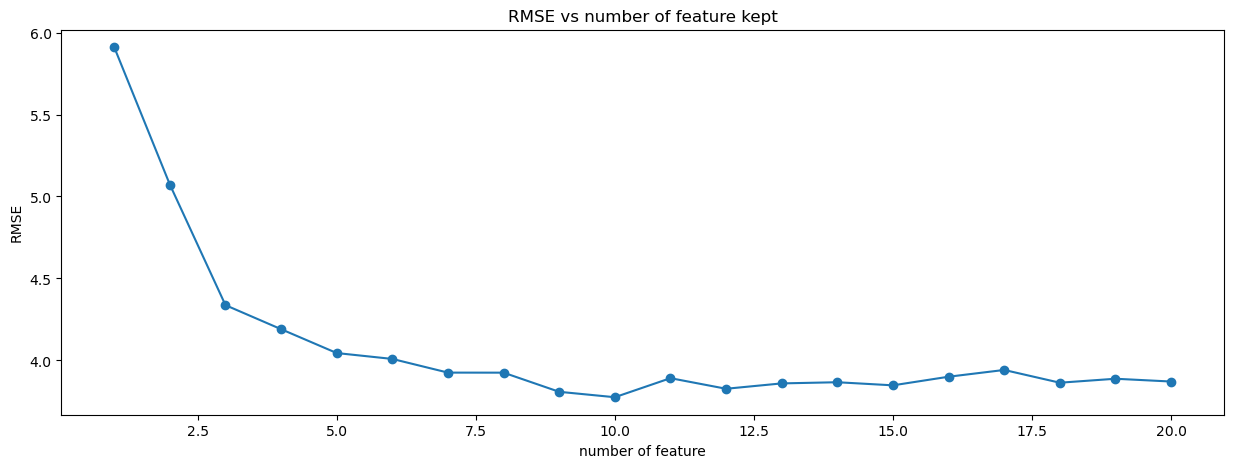

In [22]:
plt.figure(figsize=(15,5))
plt.plot([i for i in range(1,len(cv_error_list_rt)+1)], cv_error_list_rt, marker='o')
plt.title("RMSE vs number of feature kept")
plt.xlabel("number of feature")
plt.ylabel("RMSE")
plt.show()

Based on the graph above, we decided to keep only the **first 10 principal components** obtained during our f**eature selection**.Moreover, since we applied **PCA**, it is quite difficult to interpret these components directly.

In [24]:
selected_rt_guided = selected_rt[:10]
print(f"after feature selection , our RMSE is {cv_error_list_rt[9]}")

after feature selection , our RMSE is 3.7757


#### Final pipeline

After feature selection, here are the **RMSE values** obtained for our **Ridge model** and our **regression tree** (we are not comparing with the **Random Forest** here, as we did not apply feature selection to that model).

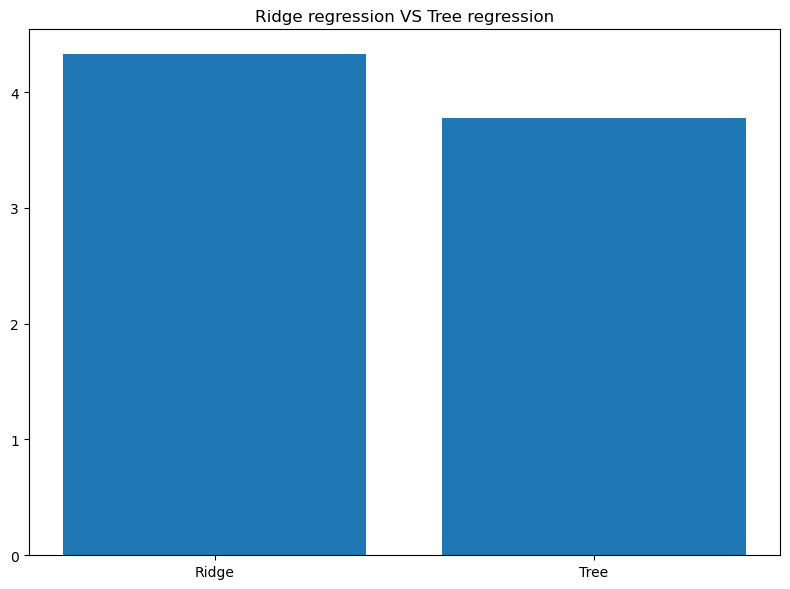

In [25]:
plt.figure(figsize=(8,6))
plt.title("Ridge regression VS Tree regression")
plt.bar(range(2), [cv_error_list_ridge[38],cv_error_list_rt[9]], align='center')
plt.xticks(range(2), ["Ridge" , "Tree"], rotation=0)
plt.tight_layout()
plt.show()

Therefore, our winning model is the **regression tree**, as it achieves the **lowest RMSE**.

In the following code, we will define our feature selection for **the regression tree** in order to build our **final pipeline**.

In [26]:
def selection_feature_tree_guided(k = 7):
    selected_rt = []
    n_features_to_select = k
    n_features = X_reg_pca_guided.shape[1] 

    kf = KFold(n_splits=5, shuffle=False)


    for round_i in tqdm(range(n_features_to_select)):
        candidates = list(set(range(n_features)) - set(selected_rt))
        cv_errors = []

        for c in candidates:
            features_to_include = selected_rt + [c]
            fold_errors = []

            for train_index, test_index in kf.split( X_reg_pca_guided):
                X_train =  X_reg_pca_guided[train_index][:, features_to_include]
                X_test =  X_reg_pca_guided[test_index][:, features_to_include]
                y_train, y_test = y_reg_guided[train_index], y_reg_guided[test_index]

                pipeline_rt_guided.fit(X_train, y_train)
                y_pred = pipeline_rt_guided.predict(X_test)
                fold_errors.append(root_mean_squared_error(y_test, y_pred))

            cv_errors.append(np.mean(fold_errors))

        best_candidate = candidates[np.argmin(cv_errors)]
        selected_rt.append(best_candidate)
        

    return(selected_rt)

Finally, we create a scikit-learn Pipeline that integrates own custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results.We also include the preliminary PCA that was performed on the data.

In [27]:
pipeline_final_guided = Pipeline([
    ("feature extraction", Transformer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("pre feature selection", pca_guided),
    ("feature selection",selection_feature_tree_guided(k = 10)),
    ("regressor", DecisionTreeRegressor(max_depth=7 , random_state=42))
])

100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


###  More sophisticated approach:

#### Riemannian Geometry-Based Approach

Here we implemented the two approaches : 

**Riemannian Geometry-Based Approach**

For our first advanced method, we relied on the PyRiemann library (https://github.com/pyRiemann/pyRiemann) to extract features from sEMG signals using covariance-based representations on the Riemannian manifold.

<u>We built a pipeline composed of the following steps<u>:

-<u>Covariance Estimation<u>: we computed the covariance matrices of EMG signals using the Covariances class with the Oracle Approximating Shrinkage (OAS) method.

-<u>Tangent Space Projection<u>: the SPD covariance matrices were projected onto the tangent space, converting them into Euclidean vectors.

-<u>Regression<u>>: we tested two models within the pipeline:

       1) Ridge regression (alpha = 25)

       2) Random Forest regression (n_estimators = 100)

After defining this pipeline, we used a 5-fold cross-validation strategy to evaluate model performance.
Here is a  simplified pseudocode : 
    
    
1)Initialize rmse_scores as an empty list

2)Split data into K folds using K-Fold cross-validation

3)For each fold:

    1.Assign current training and test indices: train_id, val_id

    2.Define training and test sets:

    X_train <- X[train_id]

    X_test <- X[val_id]

    y_train <- y[train_id]

    y_test <- y[tval_id]

    3.Fit the pipeline on the training data:
    pipeline.fit(X_train, y_train)

    4.Predict target values on the test data:
    y_pred <- pipeline.predict(X_test)

    5.Compute the RMSE for this fold:
    rmse <- sqrt(mean_squared_error(y_test, y_pred))

    6.Append rmse to rmse_scores

4)Compute final score:
average_rmse <- mean(rmse_scores)
                




In [28]:
!pip install pyriemann

We will now compare the **RMSE** of the Riemannian Geometry-Based Approach with that of a **Ridge** regression using different values of alpha.

Pipeline (Ridge) RMSE for alpha = 0.01:  4.180071510478665
Pipeline (Ridge) NMSE for alpha = 0.01:  0.11714832041971016
Pipeline (Ridge) RMSE for alpha = 0.1:  4.180045601781851
Pipeline (Ridge) NMSE for alpha = 0.1:  0.11714679405663848
Pipeline (Ridge) RMSE for alpha = 1:  4.179791506989762
Pipeline (Ridge) NMSE for alpha = 1:  0.11713181077900621
Pipeline (Ridge) RMSE for alpha = 10:  4.177721207225021
Pipeline (Ridge) NMSE for alpha = 10:  0.11700848499041017
Pipeline (Ridge) RMSE for alpha = 25:  4.175921887733561
Pipeline (Ridge) NMSE for alpha = 25:  0.11689661014999997
Pipeline (Ridge) RMSE for alpha = 50:  4.1764533440784835
Pipeline (Ridge) NMSE for alpha = 50:  0.11691335649515029
Pipeline (Ridge) RMSE for alpha = 100:  4.186143417288878
Pipeline (Ridge) NMSE for alpha = 100:  0.11745670709665582
Pipeline (Ridge) RMSE for alpha = 200:  4.222346937206739
Pipeline (Ridge) NMSE for alpha = 200:  0.1195897192623749


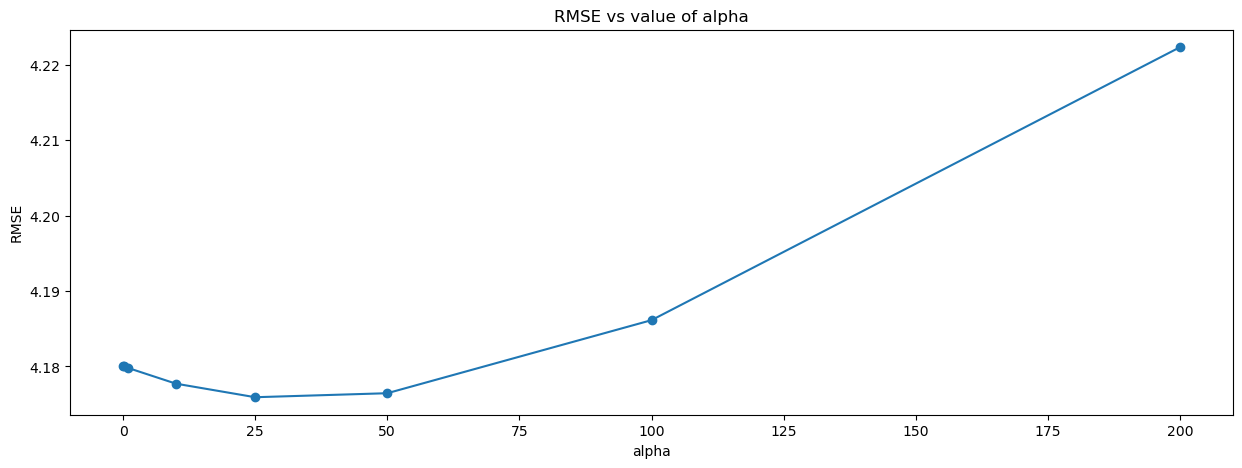

In [29]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace


kf = KFold(n_splits=5, shuffle=False)
different_alpha = [0.01, 0.1, 1, 10, 25, 50, 100, 200]
rmse_alpha_ridge_rieman = []
for alpha in different_alpha:
    pipeline_ridge_2 = Pipeline([
    ("matrix_cov", Covariances(estimator="oas")),
    ("tangent_space", TangentSpace()),
    ("scaler", StandardScaler()),
    ("regressor", Ridge(alpha = alpha, random_state=42))
    ])
    rmse_score_ridge_2=[]
    nmse_score_ridge_2 = []
    for train_id, val_id in kf.split(window_X_guided):
        X_train, X_test = window_X_guided[train_id],window_X_guided[val_id]
        y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]
        pipeline_ridge_2.fit(X_train,y_train)
        y_pred_pipe_3 = pipeline_ridge_2.predict(X_test)
        rmse_pipeline_ridge_2 = root_mean_squared_error(y_test, y_pred_pipe_3)
        rmse_score_ridge_2.append(rmse_pipeline_ridge_2)
        mse_pipeline_ridge_2  = mean_squared_error(y_test,y_pred_pipe_3)
        nmse_score_ridge_2.append(mse_pipeline_ridge_2/np.var(y_test))


    rmse_alpha_ridge_rieman.append(np.mean(rmse_score_ridge_2))
    print(f"Pipeline (Ridge) RMSE for alpha = {alpha}: ",np.mean(rmse_score_ridge_2))
    print(f"Pipeline (Ridge) NMSE for alpha = {alpha}: ",np.mean(nmse_score_ridge_2))


plt.figure(figsize=(15,5))
plt.plot(different_alpha,rmse_alpha_ridge_rieman, marker='o')
plt.title("RMSE vs value of alpha")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.show()

Here, we see that the **lowest RMSE** is obtained when we choose **alpha = 25**.

In [30]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace


kf = KFold(n_splits=5, shuffle=False)
pipeline_ridge_2_guided = Pipeline([
("matrix_cov", Covariances(estimator="oas")),
("tangent_space", TangentSpace()),
("scaler", StandardScaler()),
("regressor", Ridge(alpha = 25, random_state=42))
])
rmse_score_ridge_2=[]
nmse_score_ridge_2 = []
for train_id, val_id in kf.split(window_X_guided):
    X_train, X_test = window_X_guided[train_id],window_X_guided[val_id]
    y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]
    pipeline_ridge_2_guided.fit(X_train,y_train)
    y_pred_pipe_3 = pipeline_ridge_2_guided.predict(X_test)
    rmse_pipeline_ridge_2 = root_mean_squared_error(y_test, y_pred_pipe_3)
    rmse_score_ridge_2.append(rmse_pipeline_ridge_2)
    mse_pipeline_ridge_2  = mean_squared_error(y_test,y_pred_pipe_3)
    nmse_score_ridge_2.append(mse_pipeline_ridge_2/np.var(y_test))

    
print("Pipeline (Ridge) RMSE: ",np.mean(rmse_score_ridge_2))
print("Pipeline (Ridge) NMSE: ",np.mean(nmse_score_ridge_2))


###RANDOM FOREST

pipeline_rf_2 = Pipeline([
("matrix_cov", Covariances(estimator="oas")),
("tangent_space", TangentSpace()),
("scaler", StandardScaler()),
("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])
rmse_score_rf_2=[]
nmse_score_rf_2 = []
for train_id, val_id in kf.split(window_X_guided):
    X_train, X_test = window_X_guided[train_id],window_X_guided[val_id]
    y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]
    pipeline_rf_2.fit(X_train,y_train)
    y_pred_pipe_4 = pipeline_rf_2.predict(X_test)
    rmse_pipeline_rf_2 = root_mean_squared_error(y_test, y_pred_pipe_4)
    rmse_score_rf_2.append(rmse_pipeline_rf_2)
    mse_pipeline_rf_2  = mean_squared_error(y_test,y_pred_pipe_4)
    nmse_score_rf_2.append(mse_pipeline_rf_2/np.var(y_test))

    
print("Pipeline (Random Forest) RMSE: ",np.mean(rmse_score_rf_2))
print("Pipeline (Random Forest) NMSE: ",np.mean(nmse_score_rf_2))

Pipeline (Ridge) RMSE:  4.175921887733561
Pipeline (Ridge) NMSE:  0.11689661014999997
Pipeline (Random Forest) RMSE:  2.813601771863246
Pipeline (Random Forest) NMSE:  0.04773849243996132


Both pipelines (Ridge and Random Forest) yield an RMSE of 4.17 and 2.81, respectively, and an NMSE of 0.11 and 0.048. We therefore observe a slight improvement in RMSE and NMSE, proving the usefulness of  covariance matrices and Riemannian geometry in this problem.

####  Neural Network:

**Neural Network**
                
We used a MLP neural network for this problem.Our starting point was the symbolic-style example provided in TP4, which offered a basic structure for both building the neural network via the Simple2Layer ( we added 1 layer so now it is Simple3Layer) class and training/validating the model. The initial hyperparameters we used were:

input_dim = 72

hidden_dim = 64

output_dim = 51

eta = 1e-3

To this base code, we added two things:

     1)The splitting strategy using KFold with  k =5 (as in previous experiments),

     2)A loop over the number of epochs(=150) to allow for iterative training of the neural network.
                

However, our initial results were not convincing: the **RMSE** ranged between 9 and 10, indicating clear **underfitting** of the model. To understand where is  the issue, we printed the **training loss** (loss.item()) during each **epoch**. Interestingly, the loss **initially decreased**, then **increased mid-training**, before **decreasing again** (and so the **RMSE**).This irregular behavior suggested potential issues with the **manually implemented gradient update method from TP4**.

To address this, we explored more **advanced optimizers** and tested both **RMSprop and Adam**. **Adam** performed best in our case, we also added an **L^2 regularization**(=0.001).
Despite this improvement, the **RMSE remained relatively high** (> 5), which led us to explore further optimizations to enhance our neural network’s performance. We introduced a **mini batch**( of size=64) to train the neural network on small groups of samples (since our dataset is too large), improving stability through more frequent weight updates. We finally added the  **early stopping technique** which is a regualarization technique that stops training when the **RMSE stop improving after a defined number of steps** (in our case we put it at 15). 


In [93]:
kf = KFold(n_splits=5, shuffle=False)

class Simple3LayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)  # ReLU activation
        x = self.fc2(x)    # linear output for regression
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x
    
def RMSE(a, b):
    return torch.sqrt(torch.mean((a-b)** 2))

input_dim = 72
hidden_dim = 64 #adjustable 
output_dim = 51
eta = 1e-3 #adjustable
epoch = 150 #adjustable
batch_size = 64 #adjustable 
rmse_neural = [] 
early_stopping = 15 #adjustable
no_improvement = 0 
best_rmse = 15.0
l2_regu = 1e-3 #adjustable 
X = guided_dataset_X  
y = guided_dataset_y

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg_guided)
X_nn = torch.tensor(X_scaled, dtype=torch.float32)
y_nn = torch.tensor(y_data_preparation(y,window_size = 500,overlap = 0.5), dtype=torch.float32)

for train_id, val_id in kf.split(X_nn):
    X_train, X_test = X_nn[train_id], X_nn[val_id]
    y_train, y_test = y_nn[train_id], y_nn[val_id]
    
    model = Simple3LayerMLP(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=eta,weight_decay=l2_regu)
    #optimizer = optim.RMSprop(model.parameters(), lr=eta)
    
    #entraînement
    for i in range(epoch):
        model.train() #train the model
        optimizer.zero_grad() #reset the gradient
        for j in range(0,len(X_train),batch_size): #minibatch
            X_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]
            y_pred_train_batch = model(X_batch)
            loss = criterion(y_pred_train_batch, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 

        # Gradient descent step from TP4
        #with torch.no_grad():
            #for param in model.parameters():
                #param -= eta * param.grad
                #param.grad.zero_()
    
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            rmse = RMSE(y_pred_test,y_test)
        
        #early stopping
        if rmse < best_rmse:
            best_rmse = rmse
            no_improvement = 0
            best_model_state = model.state_dict() #save the best model
        else:
            no_improvement +=   1 
            if no_improvement >= early_stopping:
                print('no improvement of the RMSE')
                model.load_state_dict(best_model_state) #load the best model
                break

            
            
    #validation
    model_guided = model
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        rmse2 = RMSE(y_pred_test,y_test)
        print(rmse2)
    
        
        rmse_neural.append(rmse2.item())
        print(rmse_neural)

moyenne_rmse = np.mean(rmse_neural)
print(moyenne_rmse)

no improvement of the RMSE
tensor(4.9256)
[4.925594806671143]
no improvement of the RMSE
tensor(2.5107)
[4.925594806671143, 2.5107181072235107]
no improvement of the RMSE
tensor(2.3580)
[4.925594806671143, 2.5107181072235107, 2.3580117225646973]
no improvement of the RMSE
tensor(2.5896)
[4.925594806671143, 2.5107181072235107, 2.3580117225646973, 2.5896499156951904]
no improvement of the RMSE
tensor(2.1948)
[4.925594806671143, 2.5107181072235107, 2.3580117225646973, 2.5896499156951904, 2.194807291030884]
2.915756368637085


#### Comparison of the Results

This code was generated by an artificial intelligence for the structure

In [107]:
# This code was generated by an artificial intelligence.
model_names = [ 
    "Random Forest with PCA",
    "Ridge with PCA",
    "Ridge with PCA and comp selection",
    "Tree Regression with PCA",
    "Tree Regression with PCA and comp selection",
    "Ridge with Riemann geometry",
    "Random Forest with Riemann geometry",
    "Neural Network",
]
results_df = pd.DataFrame(columns=["RMSE", "NMSE", "Training Time"], index=model_names)
results_df.loc["Random Forest with PCA"] = [3.17, 0.062, "+/- 420s"]
results_df.loc["Ridge with PCA"] = [4.336, 0.124, "less than 3s"]
results_df.loc["Ridge with PCA and comp selection"] = [4.326, "", "less than 3s"]
results_df.loc["Tree Regression with PCA"] = [4.10, 0.108, "less than 3s"]
results_df.loc["Tree Regression with PCA and comp selection"] = [3.776, "", "less than 3s"]
results_df.loc["Ridge with Riemann geometry"] = [4.178, 0.117, "less than 3s"]
results_df.loc["Random Forest with Riemann geometry"] = [2.814, 0.048, "+/- 420s"]
results_df.loc["Neural Network"] = ["+/- 2.8", "", "+/- 20s"]
print(results_df)



                                                RMSE   NMSE Training Time
Random Forest with PCA                          3.17  0.062      +/- 420s
Ridge with PCA                                 4.336  0.124  less than 3s
Ridge with PCA and comp selection              4.326         less than 3s
Tree Regression with PCA                         4.1  0.108  less than 3s
Tree Regression with PCA and comp selection    3.776         less than 3s
Ridge with Riemann geometry                    4.178  0.117  less than 3s
Random Forest with Riemann geometry            2.814  0.048      +/- 420s
Neural Network                               +/- 2.8              +/- 20s


### Exercice 6

Following our feature selection obtained in the **Baseline Approach** section, we define new datasets for each of our models in order to retain only the principal components selected during feature selection.
We will then compute its **RMSE** in order to compare it with the **RMSE** of the three models from our **Baseline Approach**.

In [109]:
X_reg_rf_guided =  X_reg_pca_guided
X_reg_ridge_guided =  X_reg_pca_guided[:,selected_ridge_guided] ### keep only the features selected during the feature selection in the baseline part
X_reg_rt_guided =  X_reg_pca_guided [:, selected_rt_guided]

In [39]:
kf = KFold(n_splits=5, shuffle=False)
rmse_score_average = []
nmse_score_average = []

for train_id, val_id in kf.split(X_reg_pca_guided):
    X_test = X_reg_pca_guided[val_id]
    y_train, y_test = y_reg_guided[train_id], y_reg_guided[val_id]
    ### Random forest
    X_train_rf = X_reg_rf_guided[train_id]
    pipeline_rf.fit(X_train_rf, y_train)
    y_1 = pipeline_rf.predict(X_test)
    ### Ridge regression
    X_train_ridge = X_reg_ridge_guided[train_id]
    pipeline_ridge_guided.fit(X_train_ridge, y_train)
    y_2 = pipeline_ridge_guided.predict(X_test[:,selected_ridge_guided])
    ### Regression Tree
    X_train_rt = X_reg_rt_guided[train_id]
    pipeline_rt_guided.fit(X_train_rt, y_train)
    y_3 = pipeline_rt_guided.predict(X_test[:,selected_rt_guided])
    ### Average
    y_final = (y_1 + y_2 + y_3 )/3
    
    rmse_pipeline_rt = root_mean_squared_error(y_test, y_final)
    mse_pipeline_rt  = mean_squared_error(y_test,y_final)

    rmse_score_average.append(rmse_pipeline_rt)
    nmse_score_average.append(mse_pipeline_rt/np.var(y_test))

    

print("Pipeline (Average) RMSE: ",np.mean(rmse_score_average))
print("Pipeline (Average) NMSE: ",np.mean(nmse_score_average))


Pipeline (Average) RMSE:  3.2262861918975125
Pipeline (Average) NMSE:  0.06510849535096852


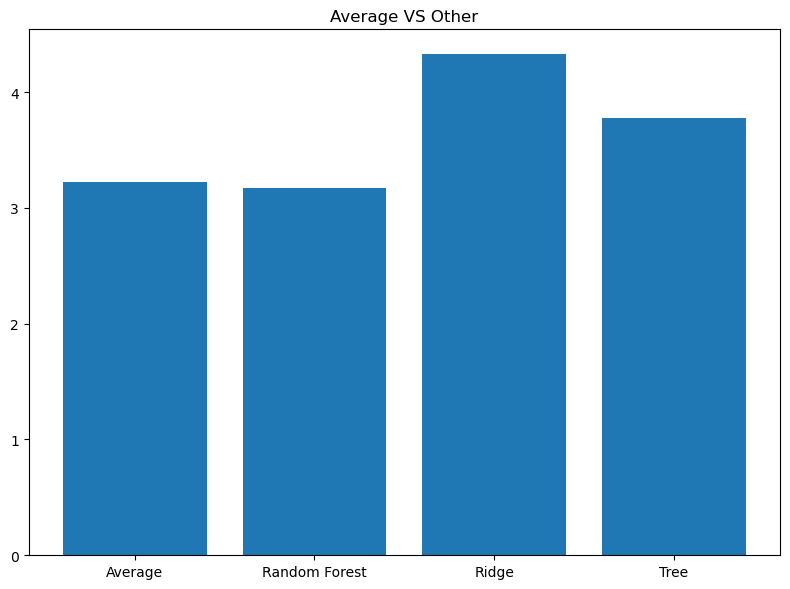

In [40]:
plt.figure(figsize=(8,6))
plt.title("Average VS Other")
plt.bar(range(4), [3.226,3.17,4.326,3.776], align='center')
plt.xticks(range(4), ["Average","Random Forest","Ridge" , "Tree"], rotation=0)
plt.tight_layout()
plt.show()

We observe that the **RMSE** is slightly higher than that of the **Random Forest** (3.17), but lower than those of **Ridge** and the **Regression Tree** (4.326 and 3.776, respectively).

This can be explained by the fact that we are **averaging predictions**. This averaging does not reduce the bias (we're simply averaging the biases),
but it does help reduce the variance, thanks to the **$n^2$ factor** in the denominator. Indeed:

$$
\mathbb{E}[\frac{1}{n} \sum_{m=1}^{n} \hat{y_m}] = \frac{1}{n} \sum_{m=1}^{n} \mathbb{E}[\hat{y_m}]  \quad \text{et} \quad \mathrm{Var}(\frac{1}{n} \sum_{m=1}^{n} \hat{y_m}) = \frac{1}{n^2} \sum_{m=1}^{n} \mathrm{Var}(\hat{y_m})
$$

The summation can be taken out of the variance here because we assumed that our **models are independent**.

**Meta-learner startegy**

The **meta-learner** is a **regression model** like any other, except that its inputs are predictions from **M other regression algorithms** (referred to as the primary layer models).
The advantage of this approach is that it combines **multiple different regression methods**, thus also combining their respective strengths.Moreover, the **meta-learner** helps reduce the risk of **overfitting**, since any **overfitting** that might occur in one of the primary layer models can be compensated for by the others.

However, it's crucial to be very careful about how we train **the meta-learner** in order to avoid **data leakage**.

The goal is to use **5-fold cross-validation** to train and validate our **meta-learner**.
However, to train (and test) the **meta-learner**, we must first train our first-layer models! Indeed, the **meta-learner** can only receive as input predictions from already trained models but we must ensure that no data point is used simultaneously to train the primary layer models and the **meta-learner** within the same fold.This separation is essential to prevent data leakage.

Here’s how we proceed:

1) We start with a **for loop based on a 5-fold split (without shuffle)**. The held-out fold will be used to generate predictions for the **meta-learner**, which will have been trained on the other 4 folds.

2) We then run a second **for loop based on a 4-fold split**.Three folds are used to train the primary layer models, and the remaining fold is used to generate predictions from these models, predictions which are then (see step 3)), used to train the **meta-learner**.This ensures that data is either used to train the primary layer models or to train the **meta-learner**, but never both, hence avoiding any **data leakage**.Note that since we perform a 4-fold (without shuffle) on the base dataset after removing 1/5 of it via the 5-fold, we are still effectively in a **leave-one-session-out setup**, so the 4-fold itself does not introduce **data leakage either**.

3) At the **end of the second for loop**, we merge all the predictions and properly format the set of predicted y values from our primary layer models to use them as input for our **meta-learner**.We then train **the meta-learner** on these predicted y values (coming from the 4 folds selected by the 5-fold split), and we can use the **trained meta-learner** to predict the remaining fold from our initial 5-fold split.At the end of this second for loop, we also record the weights or importances assigned by our **meta-learner** to the different regression models.We will take the **average of these importances over the 5 folds** (from the first for loop) to obtain the overall contribution of each regression model to our **meta-learner**.

4) And so, at the end of the first for loop, we're done ! We examine the relative importance of our models and evaluate the **final RMSE** !

In [41]:
pipeline_ridge_meta = Pipeline([ 
("imputer", SimpleImputer(strategy="mean")),
("scaler", StandardScaler()),
("regressor", Ridge(alpha = 1, random_state=42))
])
pipeline_rf_meta = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators= 10, random_state=42))
])

rmse_score_meta = []
nmse_score_meta = []
liste_coef_importance = []
rmse_score_meta_on_train = []

kf_meta = KFold(n_splits=5, shuffle=False)
kf_model = KFold(n_splits=4, shuffle=False)

for train_id_meta, val_id_meta in kf_meta.split(X_reg_pca_guided):
    X_train_meta, X_test_meta = X_reg_pca_guided[train_id_meta], X_reg_pca_guided[val_id_meta]
    y_train_meta, y_test_meta = y_reg_guided[train_id_meta], y_reg_guided[val_id_meta]
    
    liste_y_pred_rf = []
    liste_y_pred_ridge = []
    liste_y_pred_rt = []

    for train_id_model, val_id_model in kf_model.split(X_train_meta):
        X_train_model, X_test_model = X_reg_pca_guided[train_id_model], X_reg_pca_guided[val_id_model]
        y_train_model, y_test_model = y_reg_guided[train_id_model], y_reg_guided[val_id_model]        

        ### Random forest
        X_train_rf = X_reg_rf_guided[train_id_model]
        pipeline_rf_meta.fit(X_train_rf, y_train_model)
        liste_y_pred_rf.append(pipeline_rf_meta.predict(X_test_model))
        
        ### Ridge regression
        X_train_ridge, X_test_ridge = X_reg_ridge_guided[train_id_model], X_reg_ridge_guided[val_id_model]
        pipeline_ridge_guided.fit(X_train_ridge, y_train_model)
        liste_y_pred_ridge.append(pipeline_ridge_guided.predict(X_test_ridge))
        
        ### Regression Tree
        X_train_rt, X_test_rt = X_reg_rt_guided[train_id_model], X_reg_rt_guided[val_id_model]
        pipeline_rt_guided.fit(X_train_rt, y_train_model)
        liste_y_pred_rt.append(pipeline_rt_guided.predict(X_test_rt))

    
    y_pred_ridge = np.concatenate(liste_y_pred_ridge, axis=0)
    y_pred_rt = np.concatenate(liste_y_pred_rt, axis=0)
    y_pred_rf = np.concatenate(liste_y_pred_rf, axis=0)

    y_for_meta = [y_pred_ridge, y_pred_rt, y_pred_rf]
    X_new_train_meta = np.concatenate(y_for_meta, axis=1)


    #### We will now focus on the meta test phase 
    pipeline_rf_meta.fit(X_train_meta, y_train_meta)
    y_pred_pipe_rf = pipeline_rf_meta.predict(X_test_meta)
    
    pipeline_ridge_guided.fit(X_train_meta, y_train_meta)
    y_pred_pipe_ridge = pipeline_ridge_guided.predict(X_test_meta)
    
    pipeline_rt_guided.fit(X_train_meta, y_train_meta)
    y_pred_pipe_rt = pipeline_rt_guided.predict(X_test_meta)
    
    y_test_for_meta = [y_pred_pipe_ridge, y_pred_pipe_rt, y_pred_pipe_rf]
    
    
    pipeline_ridge_meta.fit(X_new_train_meta, y_train_meta)
    y_pred_pipe_train = pipeline_ridge_meta.predict(X_new_train_meta)
    rmse_score_meta_on_train.append(root_mean_squared_error(y_train_meta, y_pred_pipe_train))
    y_pred_pipe = pipeline_ridge_meta.predict(np.concatenate(y_test_for_meta, axis=1))


    rmse_pipeline_meta = root_mean_squared_error(y_test_meta, y_pred_pipe)
    mse_pipeline_meta  = mean_squared_error(y_test_meta,y_pred_pipe)


    rmse_score_meta.append(rmse_pipeline_meta)
    nmse_score_meta.append(mse_pipeline_meta/np.var(y_test_meta))
    
    
    #feature importance     
    coef_importances = pipeline_ridge_meta.named_steps["regressor"].coef_
    coefs_per_model = np.split(coef_importances, 3)
    for all_coefs_for_a_model in coefs_per_model:
        liste_coef_importance.append(np.linalg.norm(all_coefs_for_a_model))


model_importance = []
for i in range(3):  
    model_importance.append(sum(liste_coef_importance[i::3]) / len(liste_coef_importance[i::3]))

relative_importance = []
somme = sum(model_importance)
for i in model_importance:
    relative_importance.append(round(100 * i / somme, 1))
    
print(relative_importance)
print("Pipeline (Meta Learner) RMSE: ",np.mean(rmse_score_meta))
print("Pipeline (Meta Learner) NMSE: ",np.mean(nmse_score_meta))
print("tradeoff biais-variance RMSE: ",np.mean(np.array(rmse_score_meta_on_train) - np.array(rmse_score_meta)))

[np.float64(21.0), np.float64(39.0), np.float64(40.0)]
Pipeline (Meta Learner) RMSE:  5.08519010308804
Pipeline (Meta Learner) NMSE:  0.1829007695584271
tradeoff biais-variance NMSE:  0.28372116313163387


Here is how to interpret the results:

The first line shows the relative importance in pecentage that our **meta-learner** assigns to each regression model (**Random forest** then **Ridge** then **Regression Tree**). Second and third lines are the RMSE and NMSE of the **meta-learner**. And the last line is the tradeoff biais-variance.

Indeed at the end of the first *for* loop we compute the RMSE (of the **meta-learner**) for the fold that we test. But we also calculate the RMSE on our train data. Why ? Because a good approximation of the variance is the difference between the RMSE on the train and test sets. If the difference is large, it mean that the model is **overfitting** (performs well on the training data but poorly on new data, wich implies high variance). But if the difference is low and the RMSE (the one on the second line) is high, that means that the **meta-learner** is not **overfitting** but rather **underfitting**

Now let's compare the performance of the two ensembling strategies by comparing their RMSE. We can clearly see that the **Average** performs better in terms of RMSE than the **Meta-learning strategy**.

### Definition of the different prediction functions

In this section, we will define the various functions needed to make predictions with the different models mentioned above.

**Random Forest + Ridge + Regression Tree**

In [42]:
def prediction_tot_model_guided(X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the different predicted y values for each of these windows using the 3 modele describe in the section Baseline approach. (one prediction for each model)

    """

    
    kf = KFold(n_splits=5, shuffle=False)
    liste_y_pred_rf = []
    liste_y_pred_ridge = []
    liste_y_pred_rt = []

    for train_id, val_id in kf.split( X_reg_pca_guided):
        y_train = y_reg_guided[train_id]
        ### Random forest
        X_train_rf = X_reg_rf_guided[train_id]
        pipeline_rf.fit(X_train_rf, y_train)
        liste_y_pred_rf.append(pipeline_rf.predict(X_test))
        ### Ridge regression
        X_train_ridge = X_reg_ridge_guided[train_id]
        pipeline_ridge_guided.fit(X_train_ridge, y_train)
        liste_y_pred_ridge.append(pipeline_ridge_guided.predict(X_test[:,selected_ridge_guided]))
        ### Regression Tree
        X_train_rt = X_reg_rt_guided[train_id]
        pipeline_rt_guided.fit(X_train_rt, y_train)
        liste_y_pred_rt.append(pipeline_rt_guided.predict(X_test[:,selected_rt_guided]))

    y_pred_rf = np.mean( liste_y_pred_rf, axis=0)
    y_pred_ridge = np.mean( liste_y_pred_ridge, axis=0)
    y_pred_rt = np.mean( liste_y_pred_rt, axis=0)

    return [ y_pred_rf, y_pred_ridge , y_pred_rt]
    

**Riemannian Geometry-Based Approach**

In [43]:
def prediction_riemannian_model_guided (X_test):
    """
    Takes as input an X_test with shape (a, b, c), where a = the number of windows, b = the number of electrodes (8 here), and c = the window size (500 here).
    It returns a list of 2 elements containing, in order, our Riemannian Ridge prediction followed by our Riemannian Random Forest prediction.
    """

    kf = KFold(n_splits=5, shuffle=False)

    pipeline_ridge_2_guided = Pipeline([
    ("matrix_cov", Covariances(estimator="oas")),
    ("tangent_space", TangentSpace()),
    ("scaler", StandardScaler()),
    ("regressor", Ridge(alpha = 1, random_state=42))
    ])
    liste_y_pred_riemannian_ridge =[]

    for train_id, val_id in kf.split(window_X_guided):
        X_train = window_X_guided[train_id]
        y_train = y_reg_guided[train_id]
        pipeline_ridge_2_guided.fit(X_train,y_train)
        y_pred_pipe_3 = pipeline_ridge_2_guided.predict(X_test)
        liste_y_pred_riemannian_ridge.append(y_pred_pipe_3)

    y_pred_riemannian_ridge_guided = np.mean(liste_y_pred_riemannian_ridge , axis = 0)


    pipeline_rf_2 = Pipeline([
    ("matrix_cov", Covariances(estimator="oas")),
    ("tangent_space", TangentSpace()),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    liste_y_pred_riemannian_rf =[]
    
    for train_id, val_id in kf.split(window_X_guided):
        X_train = window_X_guided[train_id]
        y_train = y_reg_guided[train_id]
        pipeline_rf_2.fit(X_train,y_train)
        y_pred_pipe_4 = pipeline_rf_2.predict(X_test)
        liste_y_pred_riemannian_rf.append(y_pred_pipe_4)

    y_pred_riemannian_rf_guided = np.mean(liste_y_pred_riemannian_rf , axis = 0)

    return [y_pred_riemannian_ridge_guided , y_pred_riemannian_rf_guided ]

**Neural Network**

In [44]:
def predict_NN_guided (X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the estimated y using a neural network
    
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reg_guided)


    model_guided.eval()
    with torch.no_grad():
        y_pred_NN_guided = model_guided(torch.tensor(scaler.transform(X_test),dtype=torch.float32)).numpy()
    return y_pred_NN_guided

**Average Model**

In [45]:
def prediction_average_model_guided(X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the different predicted y values for each of these windows using the average of the 3 modele describe in the section Baseline approach

    """

    kf = KFold(n_splits=5, shuffle=False)
    liste_y_pred_rf = []
    liste_y_pred_ridge = []
    liste_y_pred_rt = []

    for train_id, val_id in kf.split( X_reg_pca_guided):
        y_train = y_reg_guided[train_id]
        ### Random forest
        X_train_rf = X_reg_rf_guided[train_id]
        pipeline_rf.fit(X_train_rf, y_train)
        liste_y_pred_rf.append(pipeline_rf.predict(X_test))
        ### Ridge regression
        X_train_ridge = X_reg_ridge_guided[train_id]
        pipeline_ridge_guided.fit(X_train_ridge, y_train)
        liste_y_pred_ridge.append(pipeline_ridge_guided.predict(X_test[:,selected_ridge_guided]))
        ### Regression Tree
        X_train_rt = X_reg_rt_guided[train_id]
        pipeline_rt_guided.fit(X_train_rt, y_train)
        liste_y_pred_rt.append(pipeline_rt_guided.predict(X_test[:,selected_rt_guided]))

    y_pred_rf = np.mean( liste_y_pred_rf, axis=0)
    y_pred_ridge = np.mean( liste_y_pred_ridge, axis=0)
    y_pred_rt = np.mean( liste_y_pred_rt, axis=0)

    y_pred = (y_pred_rf + y_pred_ridge + y_pred_rt)/3

    return (y_pred)

**Meta-learner startegy**

In [100]:
def predict_meta_learner_guided (X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the estimated y using a meta-learner stategy
    """

    pipeline_ridge_meta = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha = 1, random_state=42))
    ])
    pipeline_rf_meta = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor(n_estimators= 10, random_state=42))
    ])

    liste_pred_meta = []

    kf_meta = KFold(n_splits=5, shuffle=False)
    kf_model = KFold(n_splits=4, shuffle=False)

    for train_id_meta, val_id_meta in kf_meta.split(X_reg_pca_guided):
        X_train_meta, X_test_meta = X_reg_pca_guided[train_id_meta], X_test
        y_train_meta = y_reg_guided[train_id_meta]
    
        liste_y_pred_rf = []
        liste_y_pred_ridge = []
        liste_y_pred_rt = []

        for train_id_model, val_id_model in kf_model.split(X_train_meta):
            X_train_model, X_test_model = X_reg_pca_guided[train_id_model], X_reg_pca_guided[val_id_model]
            y_train_model, y_test_model = y_reg_guided[train_id_model], y_reg_guided[val_id_model]        

            ### Random forest
            X_train_rf = X_reg_rf_guided[train_id_model]
            pipeline_rf_meta.fit(X_train_rf, y_train_model)
            liste_y_pred_rf.append(pipeline_rf_meta.predict(X_test_model))
        
            ### Ridge regression
            X_train_ridge, X_test_ridge = X_reg_ridge_guided[train_id_model], X_reg_ridge_guided[val_id_model]
            pipeline_ridge_guided.fit(X_train_ridge, y_train_model)
            liste_y_pred_ridge.append(pipeline_ridge_guided.predict(X_test_ridge))
        
            ### Regression Tree
            X_train_rt, X_test_rt = X_reg_rt_guided[train_id_model], X_reg_rt_guided[val_id_model]
            pipeline_rt_guided.fit(X_train_rt, y_train_model)
            liste_y_pred_rt.append(pipeline_rt_guided.predict(X_test_rt))

    
        y_pred_ridge = np.concatenate(liste_y_pred_ridge, axis=0)
        y_pred_rt = np.concatenate(liste_y_pred_rt, axis=0)
        y_pred_rf = np.concatenate(liste_y_pred_rf, axis=0)

        y_for_meta = [y_pred_ridge, y_pred_rt, y_pred_rf]
        X_new_train_meta = np.concatenate(y_for_meta, axis=1)


        #### on s'occupe maintenant de la partie test de meta  
        pipeline_rf_meta.fit(X_train_meta, y_train_meta)
        y_pred_pipe_rf = pipeline_rf_meta.predict(X_test_meta)
    
        pipeline_ridge_guided.fit(X_train_meta, y_train_meta)
        y_pred_pipe_ridge = pipeline_ridge_guided.predict(X_test_meta)
    
        pipeline_rt_guided.fit(X_train_meta, y_train_meta)
        y_pred_pipe_rt = pipeline_rt_guided.predict(X_test_meta)
    
        y_test_for_meta = [y_pred_pipe_ridge, y_pred_pipe_rt, y_pred_pipe_rf]
    
    
        pipeline_ridge_meta.fit(X_new_train_meta, y_train_meta)
        y_pred_pipe = pipeline_ridge_meta.predict(np.concatenate(y_test_for_meta, axis=1))

        liste_pred_meta.append(y_pred_pipe)


    return np.mean(liste_pred_meta, axis = 0)

## Free geasture dataset

### Variable Definitions and Data Formatting

Let's start by defining a few global variables that we will need throughout the following code sections.

Since our **inputs** are the same for all our regression models, we format the data only once here. This allows us to directly feed what we’ll call **X_reg_freemoves** and **y_reg_freemoves** into our regression models.

Here’s what happens concretely:

1) We begin by applying our preprocessing functions to X and y to obtain a single sequence of windows, as previously explained.

2) We then call our **Transformer class**, which, for each window of X, converts the data into our **selected features**. This is done for each electrode, as the relevance and usefulness of each **feature** (for predicting y) may depend on the specific electrode.

3) In the end, we obtain a matrix of shape (5395, 72) for X and (5395, 51) for y, where 5395 is the number of windows, 72 is the number of **features** (9 multiplied by the number of electrodes), and 51 is the number of values to predict for hand pose (see introduction).

In [47]:
X = freemoves_dataset_X  
y = freemoves_dataset_y
transformer= Transformer()
window_X_freemoves = X_data_preparation(X, window_size = 500,overlap = 0.5)
X_reg_freemoves = Transformer().transform(window_X_freemoves)
y_reg_freemoves = y_data_preparation(y,window_size = 500,overlap = 0.5)
print(X_reg_freemoves.shape)
print(y_reg_freemoves.shape)

feature_names = ["MAV", "RMS", "VAR", "STD", "ZC" ,"MPR", "MED", "WL","WAMP"]
feature_names_electrode = [f"{feature}_elect{electrode+1}" for electrode in range(8) for feature in feature_names]

(5395, 72)
(5395, 51)


### Visualisation 

We see that the variance for the **freemoves gesture** is much higher than for the **guided gesture**. This suggests that the **freemoves gestures** will be much more difficult to predict, and therefore we can expect higher RMSE values. Let's see if we're right and run our regression models. 

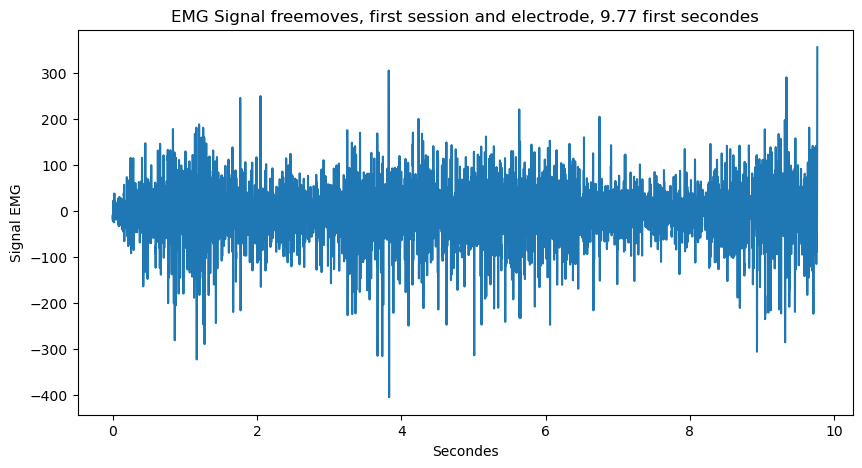

In [53]:
signal_emg = freemoves_dataset_X[0,0,:10000]
hz = 1024
temps_sec = 10000/hz
x = np.linspace(0,temps_sec,10000)
plt.figure(figsize=(10,5))
plt.plot(x,signal_emg)
plt.title(f"EMG Signal freemoves, first session and electrode, {temps_sec:.2f} first secondes")
plt.xlabel("Secondes")
plt.ylabel("Signal EMG")
plt.show()

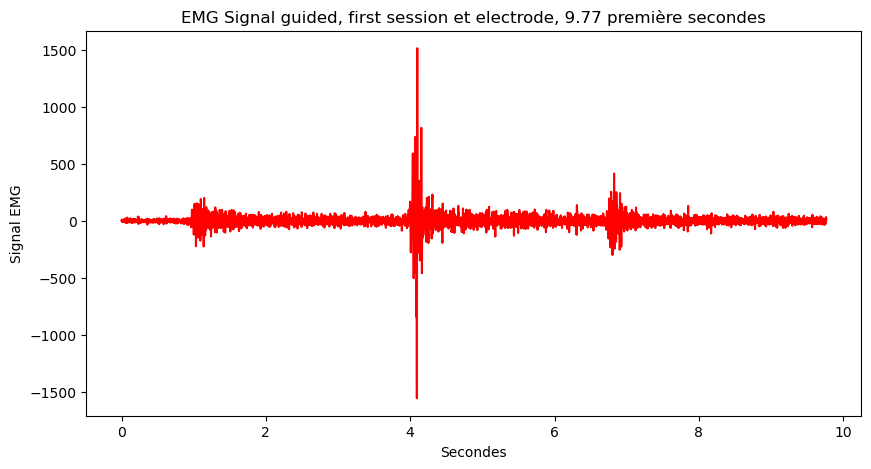

In [66]:
signal_guided_emg = guided_dataset_X[0,0,:10000]
hz = 1024
temps_sec = 10000/hz
x = np.linspace(0,temps_sec,10000)
plt.figure(figsize=(10,5))
plt.plot(x,signal_guided_emg, color='red')
plt.title(f"EMG Signal guided, first session et electrode, {temps_sec:.2f} première secondes")
plt.xlabel("Secondes")
plt.ylabel("Signal EMG")
plt.show()

As in the case of **Guided**, we will perform a **PCA** to reduce the dimensionality of our data.


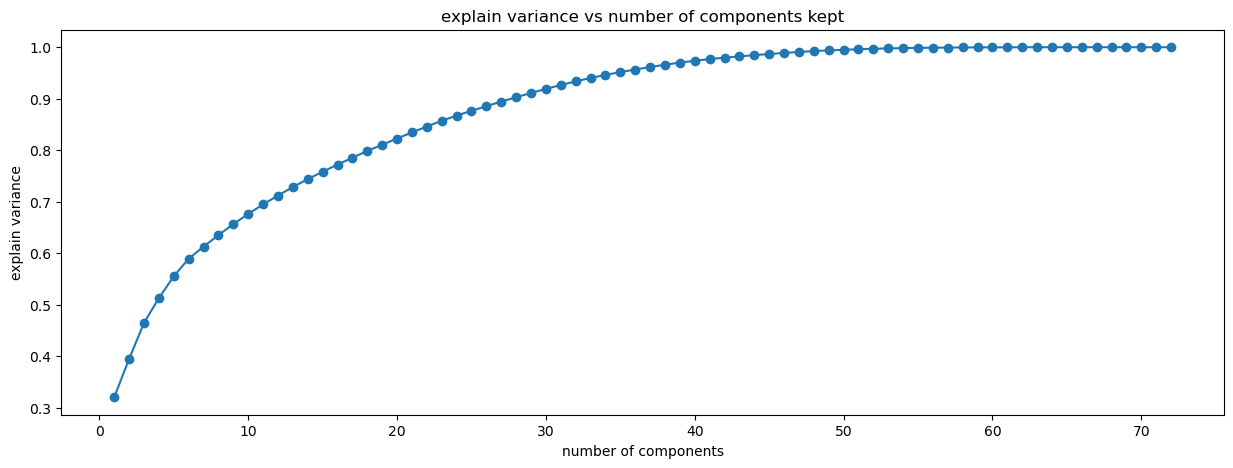

In [51]:
pca_freemoves = PCA()
scaler_freemoves = StandardScaler()
pca_freemoves.fit(scaler_freemoves.fit_transform(X_reg_freemoves))

plt.figure(figsize=(15,5))
plt.plot([i for i in range(1,len(pca_freemoves.explained_variance_ratio_)+1)], np.cumsum(pca_freemoves.explained_variance_ratio_), marker='o')
plt.title("explain variance vs number of components kept")
plt.xlabel("number of components")
plt.ylabel("explain variance")
plt.show()

In [52]:
print(np.sum(pca_freemoves.explained_variance_ratio_[:47]))
nb_composante_keep_freemoves = 47

0.9908318416057617


A calculation of the cumulative explained variance shows that to reach the 99% threshold, we need to retain the first **47 principal components !**

In [54]:
n = X_reg_freemoves.shape[1]
pca_freemoves = PCA(n_components = nb_composante_keep_freemoves)
X_reg_pca_freemoves = pca_freemoves.fit_transform(X_reg_freemoves)
principal_componant_freemoves = [f"composante principale_{i+1}" for i in range(nb_composante_keep_freemoves)]

### Random forest 

Here is our first regression model: a **Random Forest**, we will compute the **RMSE, NMSE, and the feature importances**.

To implement cross-validation, we chose to use a **K-Fold with 5 splits**. This effectively acts as a **Leave One Session Out approach**.

Indeed, at each iteration of the loop, we train on 4 of the 5 sessions and validate on the remaining one. This method helps **minimize overfitting** of our model.

Regarding **feature importance**, at each fold we compute the **feature importance** specific to that training using the **.feature_importances_** attribute from the **RandomForestRegressor class**, which measures the relative importance of our features. After the loop, we **average the feature importance values component-wise** to obtain a **final feature importance vector**, which we will plot to visualize the influence of each feature (which are now principal components from our **PCA**).

Important note: we set *random_state* = 42 so that our RMSE and NMSE comparisons are not affected by randomness—ensuring reproducibility. For all other regression models, we will also use random_state = 42.

The choice **n = 100** for the number of trees in the Random Forest is a common one and also gave us satisfactory results in practice when testing different values of n.

(47,)


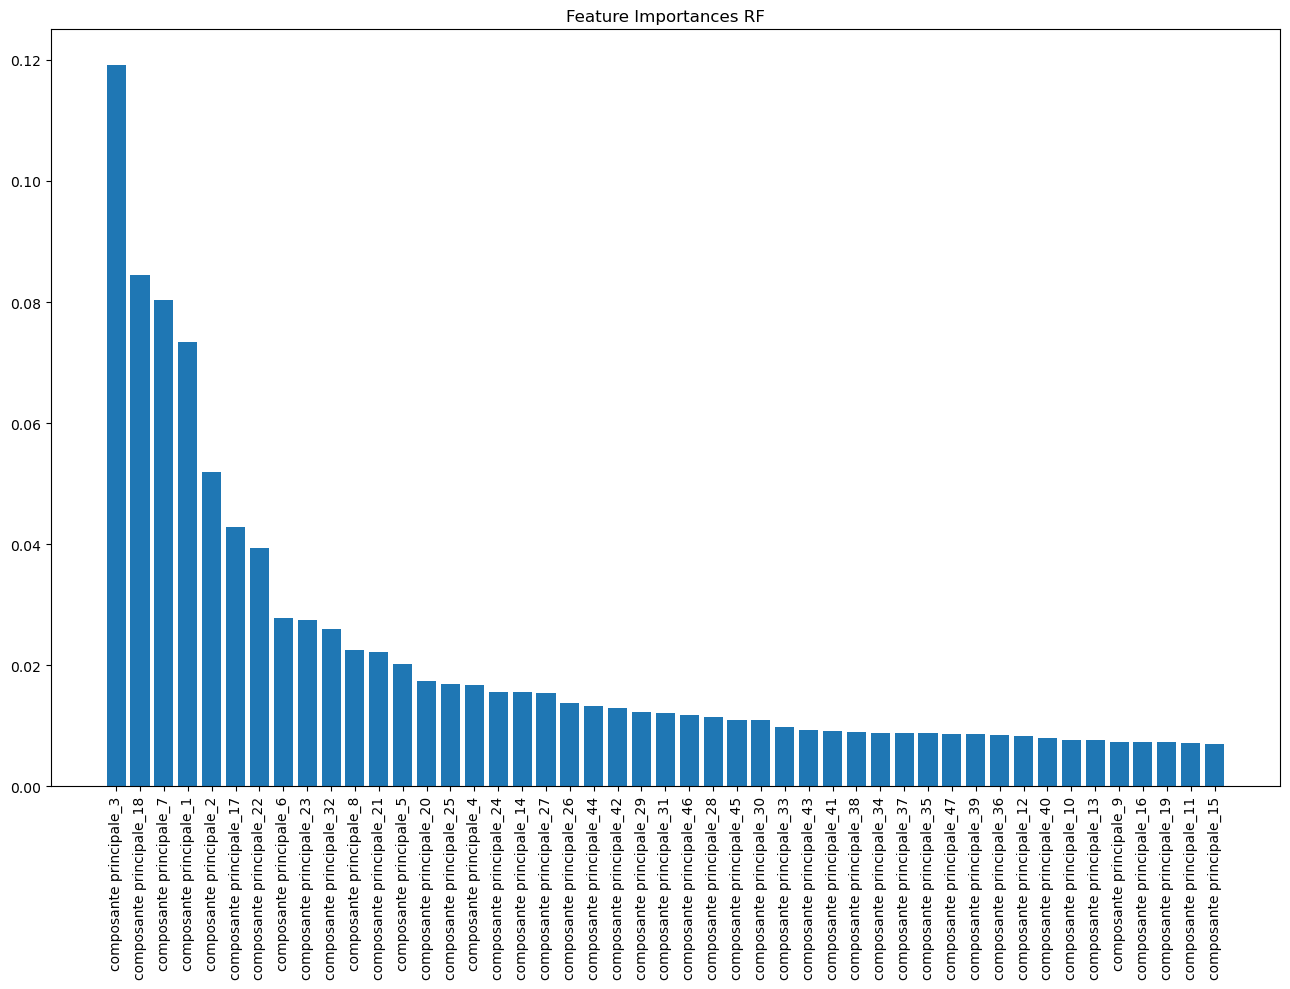

Pipeline (Random Forest) RMSE:  6.439601840613771
Pipeline (Random Forest) NMSE:  0.1962428828990809


In [55]:
pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

kf = KFold(n_splits=5, shuffle=False)
rmse_score_rf = []
nmse_score_rf = []
liste_importance = []

for train_id, val_id in kf.split(X_reg_pca_freemoves):
    X_train, X_test = X_reg_pca_freemoves[train_id], X_reg_pca_freemoves[val_id]
    y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]

    pipeline_rf.fit(X_train, y_train)
    y_pred_pipe = pipeline_rf.predict(X_test)


    rmse_pipeline_rf = root_mean_squared_error(y_test, y_pred_pipe)
    mse_pipeline_rf  = mean_squared_error(y_test,y_pred_pipe)


    rmse_score_rf.append(rmse_pipeline_rf)
    nmse_score_rf.append(mse_pipeline_rf/np.var(y_test))
    
    
    #feature importance     
    importances = pipeline_rf.named_steps["regressor"].feature_importances_
    liste_importance.append(importances)


importances_final = np.mean( liste_importance, axis=0)
indices = np.argsort(importances_final)[::-1]
print(importances_final.shape)
plt.figure(figsize=(13,10))
plt.title("Feature Importances RF")
plt.bar(range(len(importances_final)), importances_final[indices], align='center')
plt.xticks(range(len(importances_final)), [principal_componant_freemoves[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
###plt.bar(range(len(forest_importances)), forest_importances[forest_sorted_idx], align='center', color='green')
###plt.xticks(range(len(forest_importances)), feature_names[forest_sorted_idx], rotation=45)

print("Pipeline (Random Forest) RMSE: ",np.mean(rmse_score_rf))
print("Pipeline (Random Forest) NMSE: ",np.mean(nmse_score_rf))


And here are our first **RMSE and NMSE** results ! At this stage, it's not yet possible to compare them with those of other models so we'll do that later. As for the **feature importance**, the plot clearly shows a significant difference in the contribution of various features to the prediction of y.

However, we cannot simply select the **top n features** from the plot, as these do not necessarily minimize the **RMSE** (as required in the assignment instructions). For **feature selection**, we intended to apply the method introduced during the lab session (and used for Ridge): **the Forward Wrapped Method**. This method iteratively tests the addition of each feature to the current set by evaluating the model’s RMSE at each step.

However, since a **Random Forest is a non-linear model** and takes time to train, applying the forward wrapped method requires training many **Random Forests**, making the **complexity exponential**. As a result, our code took too long to run, so we decided not to include it.

### Ridge regression 

Here is our second regression model: **Ridge regression**. The process is exactly the same as with our **Random Forest model** (we simply change the regression model within the pipeline).We will compute the **RMSE, the NMSE, and the feature importances**.

Let’s now discuss the choice of **alpha** for our Ridge regression.We will test several values of alpha and identify the one that minimizes the **RMSE**.

Pipeline (Random Forest) RMSE for alpha = 0.01:  6.624948509626742
Pipeline (Random Forest) NMSE:for alpha = 0.01:  0.21080006405739704
Pipeline (Random Forest) RMSE for alpha = 0.1:  6.624931401970149
Pipeline (Random Forest) NMSE:for alpha = 0.1:  0.2107986364521081
Pipeline (Random Forest) RMSE for alpha = 1:  6.6247605211133145
Pipeline (Random Forest) NMSE:for alpha = 1:  0.21078437582679238
Pipeline (Random Forest) RMSE for alpha = 10:  6.623071166417768
Pipeline (Random Forest) NMSE:for alpha = 10:  0.21064330270559103
Pipeline (Random Forest) RMSE for alpha = 50:  6.615978368477282
Pipeline (Random Forest) NMSE:for alpha = 50:  0.21004901079757196
Pipeline (Random Forest) RMSE for alpha = 100:  6.608012387409472
Pipeline (Random Forest) NMSE:for alpha = 100:  0.20937682163876142
Pipeline (Random Forest) RMSE for alpha = 150:  6.600968532014143
Pipeline (Random Forest) NMSE:for alpha = 150:  0.20877682611153778
Pipeline (Random Forest) RMSE for alpha = 200:  6.594771446691735
Pi

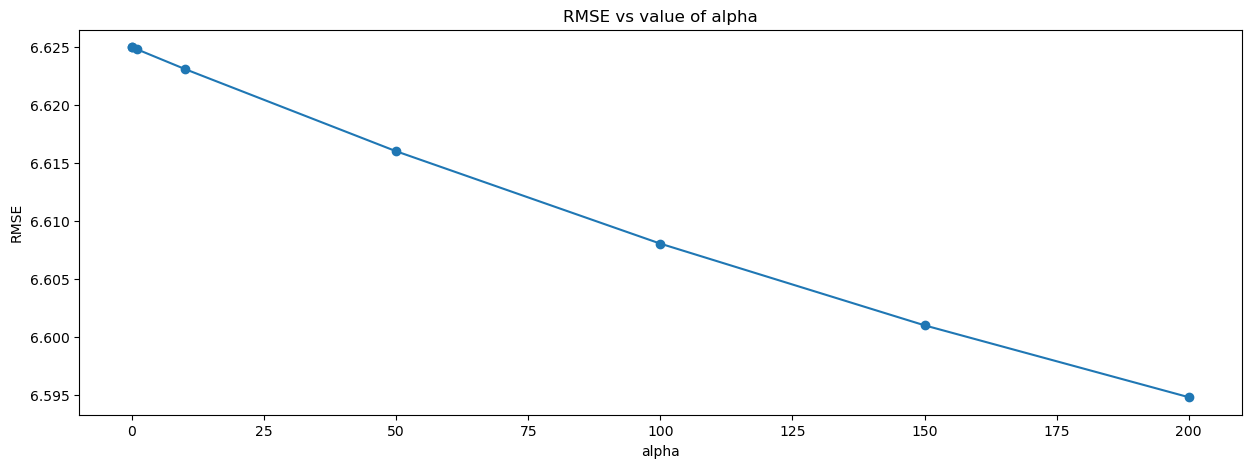

In [56]:
different_alpha = [0.01, 0.1, 1, 10, 50, 100, 150, 200]
rmse_alpha_ridge = []
for alpha in different_alpha:
    pipeline_ridge = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", Ridge(alpha = alpha, random_state=42))
    ])
    kf = KFold(n_splits=5, shuffle=False)
    rmse_score_ridge = []
    nmse_score_ridge = []
    liste_importance = []

    for train_id, val_id in kf.split(X_reg_pca_freemoves):
        X_train, X_test = X_reg_pca_freemoves[train_id], X_reg_pca_freemoves[val_id]
        y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]

        pipeline_ridge.fit(X_train, y_train)
        y_pred_pipe = pipeline_ridge.predict(X_test)


        rmse_pipeline_ridge = root_mean_squared_error(y_test, y_pred_pipe)
        mse_pipeline_ridge  = mean_squared_error(y_test,y_pred_pipe)


        rmse_score_ridge.append(rmse_pipeline_ridge)
        nmse_score_ridge.append(mse_pipeline_ridge/np.var(y_test))


    rmse_alpha_ridge.append(np.mean(rmse_score_ridge))
    print(f"Pipeline (Random Forest) RMSE for alpha = {alpha}: ",np.mean(rmse_score_ridge))
    print(f"Pipeline (Random Forest) NMSE:for alpha = {alpha}: ",np.mean(nmse_score_ridge))
    
plt.figure(figsize=(15,5))
plt.plot(different_alpha,rmse_alpha_ridge, marker='o')
plt.title("RMSE vs value of alpha")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.show()


As a result, we observe that when **alpha = 200**, the **RMSE** is the lowest.Therefore, we will use **alpha = 200** in our pipeline.

Here, we will determine the **feature importances** of our **Ridge regression model**.

(47,)
(47,)


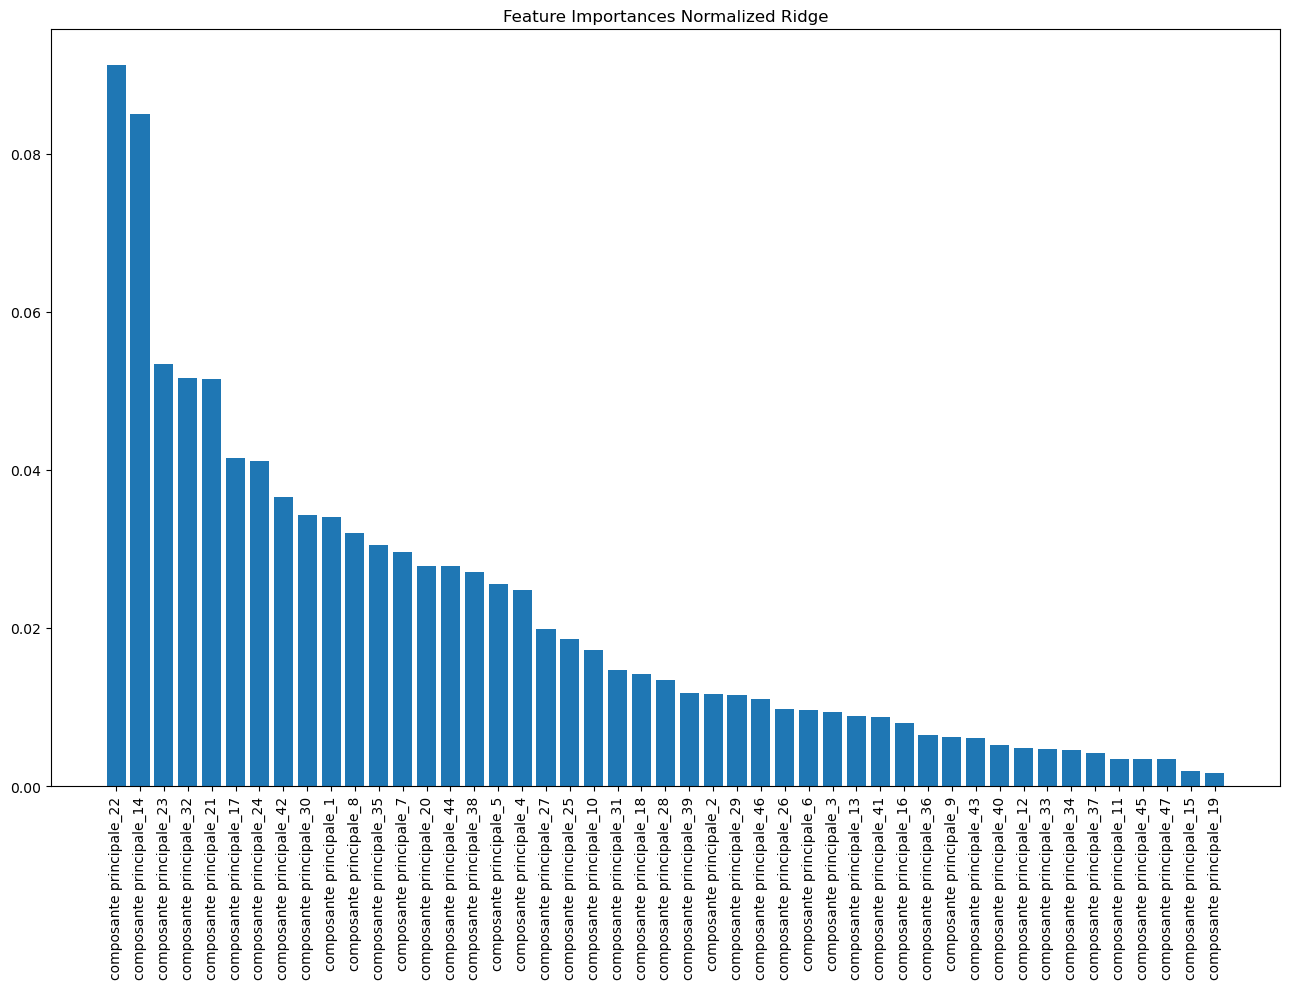

Pipeline (Random Forest) RMSE:  6.594771446691735
Pipeline (Random Forest) NMSE:  0.20824293543735992


In [57]:
pipeline_ridge_freemoves = Pipeline([
("imputer", SimpleImputer(strategy="mean")),
("scaler", StandardScaler()),
("regressor", Ridge(alpha = 200, random_state=42))
])
kf = KFold(n_splits=5, shuffle=False)
rmse_score_ridge = []
nmse_score_ridge = []
liste_importance = []

for train_id, val_id in kf.split(X_reg_pca_freemoves):
    X_train, X_test = X_reg_pca_freemoves[train_id], X_reg_pca_freemoves[val_id]
    y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]

    pipeline_ridge_freemoves.fit(X_train, y_train)
    y_pred_pipe = pipeline_ridge_freemoves.predict(X_test)


    rmse_pipeline_ridge = root_mean_squared_error(y_test, y_pred_pipe)
    mse_pipeline_ridge  = mean_squared_error(y_test,y_pred_pipe)


    rmse_score_ridge.append(rmse_pipeline_ridge)
    nmse_score_ridge.append(mse_pipeline_ridge/np.var(y_test))
    
    
    #feature importance     
    importances = pipeline_ridge_freemoves.named_steps["regressor"].coef_
    liste_importance.append(np.abs(importances[1]))


importances_final = np.mean( liste_importance, axis=0)
importances_final = importances_final / importances_final.sum()
indices = np.argsort(importances_final)[::-1]
print(importances_final.shape)
print(indices.shape)
plt.figure(figsize=(13,10))
plt.title("Feature Importances Normalized Ridge")
plt.bar(range(len(importances_final)), importances_final[indices], align='center')
plt.xticks(range(len(importances_final)), [principal_componant_freemoves[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


print("Pipeline (Random Forest) RMSE: ",np.mean(rmse_score_ridge))
print("Pipeline (Random Forest) NMSE: ",np.mean(nmse_score_ridge))


Now that we have these results, we can compare them with those of our **Random Forest**.In terms of computation time, there's no comparison  **Ridge** runs in about 10 seconds, whereas the **Random Forest** takes roughly **400 seconds**.However, both the **NMSE and RMSE** are fairly similar in the two cases.That said, the Random Forest remains more performant, which is intuitive considering that in the context of predicting hand movements from EMG signals, there are many non-linear dependencies.

Next, we will perform **feature selection** on the **Ridge regression model** using the **forward wrapped method** function from TP5.




In [58]:
selected_ridge = []
n_features_to_select = 47 # ajustable
n_features = X_reg_pca_freemoves.shape[1]
 

kf = KFold(n_splits=5, shuffle=False)
cv_error_list_ridge = []

for round_i in range(n_features_to_select):
    candidates = list(set(range(n_features)) - set(selected_ridge))
    cv_errors = []

    for c in candidates:
        features_to_include = selected_ridge + [c]
        fold_errors = []

        for train_index, test_index in kf.split(X_reg_pca_freemoves):
            X_train = X_reg_pca_freemoves[train_index][:, features_to_include]
            X_test = X_reg_pca_freemoves[test_index][:, features_to_include]
            y_train, y_test = y_reg_freemoves[train_index], y_reg_freemoves[test_index]

            model = Pipeline([("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler()),
                ("regressor", Ridge(alpha=200))
            ])
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_errors.append(root_mean_squared_error(y_test, y_pred))

        cv_errors.append(np.mean(fold_errors))

    best_candidate = candidates[np.argmin(cv_errors)]
    cv_error_list_ridge.append(round(min(cv_errors),4))
    selected_ridge.append(best_candidate)
    print("Round", round_i+1, "; Selected feature:", best_candidate,
          "; CV RMSE=", round(min(cv_errors),4))
        
        
print(" Final selected feature indices:", selected_ridge)
for number in selected_ridge:
    component = principal_componant_freemoves[number]
    print(component)

Round 1 ; Selected feature: 16 ; CV RMSE= 7.5476
Round 2 ; Selected feature: 17 ; CV RMSE= 7.3413
Round 3 ; Selected feature: 21 ; CV RMSE= 7.1678
Round 4 ; Selected feature: 0 ; CV RMSE= 7.0394
Round 5 ; Selected feature: 19 ; CV RMSE= 6.967
Round 6 ; Selected feature: 13 ; CV RMSE= 6.8693
Round 7 ; Selected feature: 2 ; CV RMSE= 6.8144
Round 8 ; Selected feature: 6 ; CV RMSE= 6.7622
Round 9 ; Selected feature: 20 ; CV RMSE= 6.7127
Round 10 ; Selected feature: 31 ; CV RMSE= 6.6697
Round 11 ; Selected feature: 4 ; CV RMSE= 6.6378
Round 12 ; Selected feature: 22 ; CV RMSE= 6.6153
Round 13 ; Selected feature: 29 ; CV RMSE= 6.5962
Round 14 ; Selected feature: 7 ; CV RMSE= 6.5795
Round 15 ; Selected feature: 43 ; CV RMSE= 6.565
Round 16 ; Selected feature: 23 ; CV RMSE= 6.5522
Round 17 ; Selected feature: 44 ; CV RMSE= 6.543
Round 18 ; Selected feature: 46 ; CV RMSE= 6.5355
Round 19 ; Selected feature: 27 ; CV RMSE= 6.5285
Round 20 ; Selected feature: 35 ; CV RMSE= 6.5224
Round 21 ; Select

Let's plot the **RMSE** as a function of the number of **selected features**.

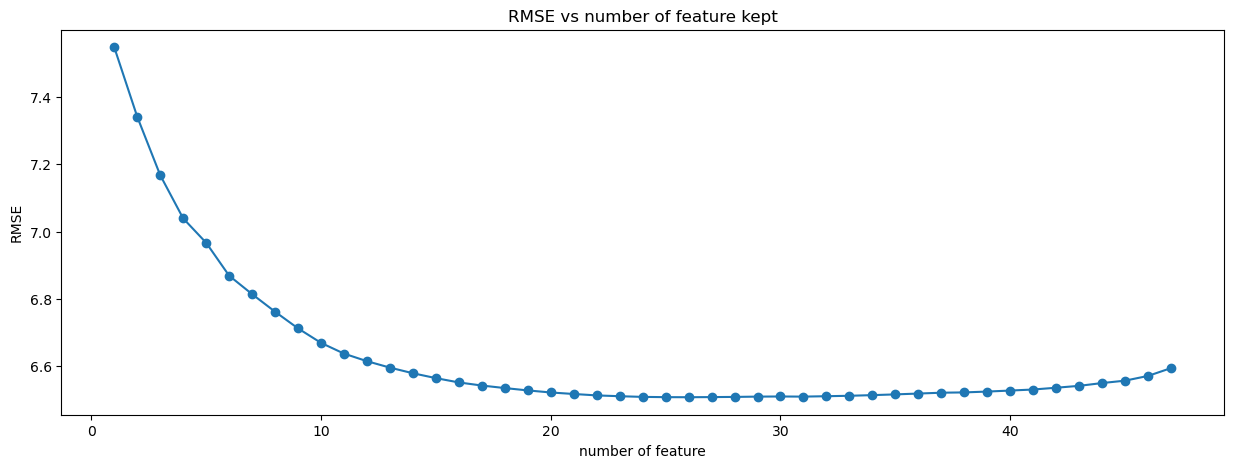

In [59]:
plt.figure(figsize=(15,5))
plt.plot([i for i in range(1,len(cv_error_list_ridge)+1)], cv_error_list_ridge, marker='o')
plt.title("RMSE vs number of feature kept")
plt.xlabel("number of feature")
plt.ylabel("RMSE")
plt.show()

By analyzing the plot, we observe a minimum at 26.Therefore, we keep the subset of the **first 26 features** from our feature selection.

In [60]:
selected_ridge_freemoves = selected_ridge[:26]
print(f"after our feature selection , our rmse is {cv_error_list_ridge[25]}")

after our feature selection , our rmse is 6.5083


### Tree regression

First, just like for **Guided**, we will determine the optimal depht for our **tree regression**. To do this, we will test multiple différent depths and keep the one with the lowest RMSE. Then, we will plot the results for easier interpretation.

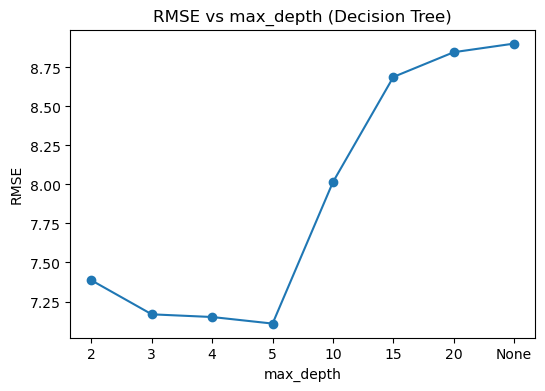

In [61]:
depths = [2, 3 , 4, 5, 10, 15, 20, None]
rmse_values_tree = []
kf = KFold(n_splits=5, shuffle=False)

for d in depths:
    rmse_values_cv = []
    pipeline_rt = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", DecisionTreeRegressor(max_depth=d,random_state=42))
    ])
    for train_id, val_id in kf.split(X_reg_pca_freemoves):
        X_train, X_test = X_reg_pca_freemoves[train_id], X_reg_pca_freemoves[val_id]
        y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]

        pipeline_rt.fit(X_train, y_train)
        y_pred_pipe_rt = pipeline_rt.predict(X_test)
        
        rmse_values_cv.append(root_mean_squared_error(y_test, y_pred_pipe_rt))
        
    rmse_values_tree.append(np.mean(rmse_values_cv))

plt.figure(figsize=(6,4))
plt.plot([str(d) for d in depths], rmse_values_tree, marker='o')
plt.title("RMSE vs max_depth (Decision Tree)")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.show()

Here we see that the RMSE is the lowest at depth = 5. We will therefore use this depth of 5 in the following steps.

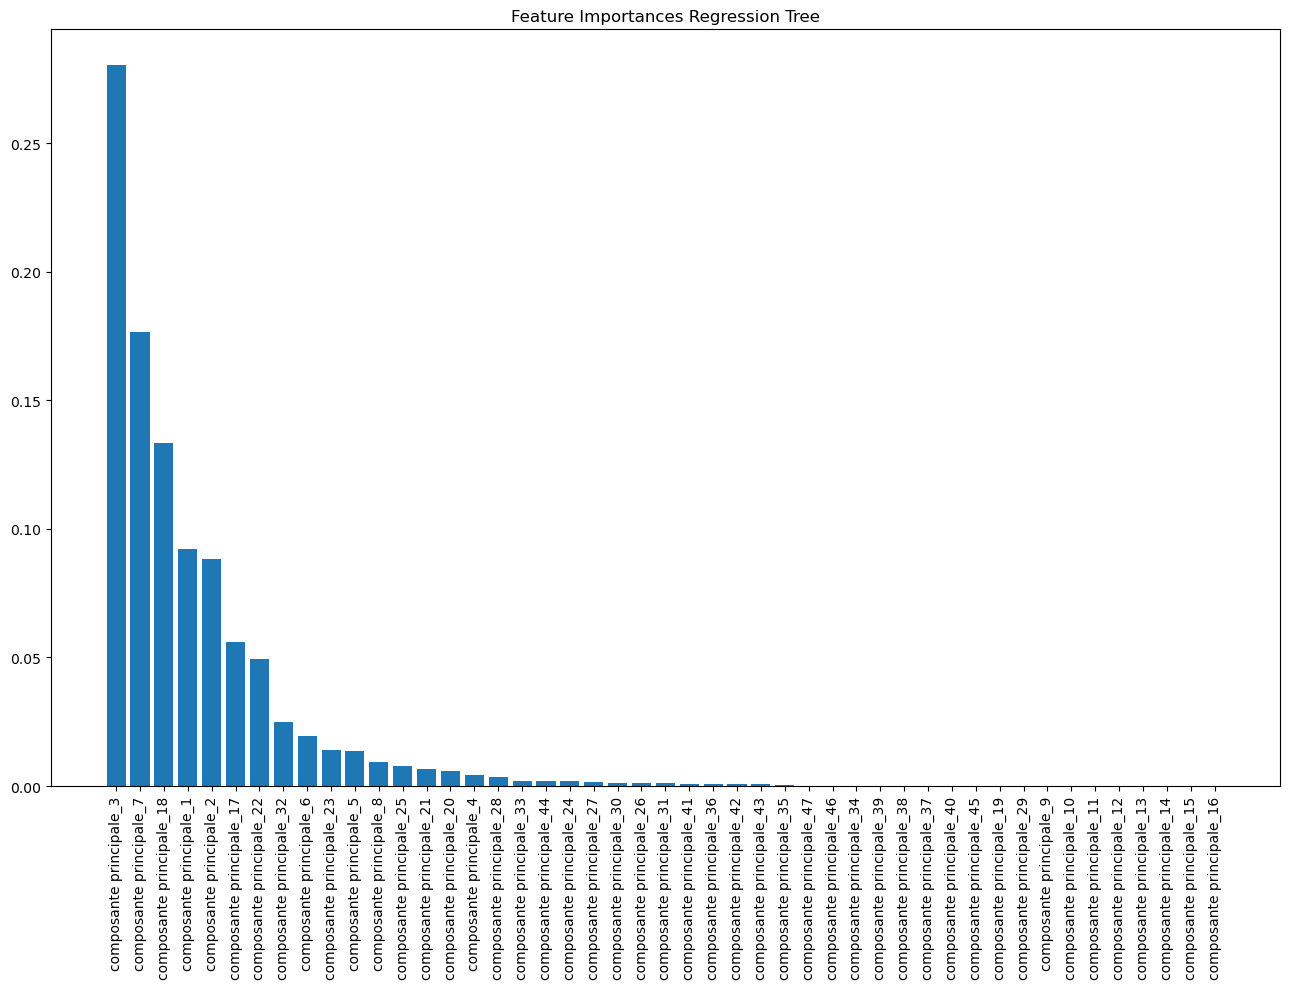

Pipeline (Regression Tree) RMSE:  7.108797748717782
Pipeline (Regression Tree) NMSE:  0.2449487770380255


In [62]:
pipeline_rt_freemoves = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", DecisionTreeRegressor(max_depth=5 , random_state=42))
])

kf = KFold(n_splits=5, shuffle=False)
rmse_score_rt = []
nmse_score_rt = []
liste_importance = []

for train_id, val_id in kf.split(X_reg_pca_freemoves):
    X_train, X_test = X_reg_pca_freemoves[train_id], X_reg_pca_freemoves[val_id]
    y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]

    pipeline_rt_freemoves.fit(X_train, y_train)
    y_pred_pipe = pipeline_rt_freemoves.predict(X_test)


    rmse_pipeline_rt = root_mean_squared_error(y_test, y_pred_pipe)
    mse_pipeline_rt  = mean_squared_error(y_test,y_pred_pipe)


    rmse_score_rt.append(rmse_pipeline_rt)
    nmse_score_rt.append(mse_pipeline_rt/np.var(y_test))
    
    
    #feature importance     
    importances = pipeline_rt_freemoves.named_steps["regressor"].feature_importances_
    liste_importance.append(importances)


importances_final = np.mean( liste_importance, axis=0)
indices = np.argsort(importances_final)[::-1]
plt.figure(figsize=(13,10))
plt.title("Feature Importances Regression Tree")
plt.bar(range(len(importances_final)), importances_final[indices], align='center')
plt.xticks(range(len(importances_final)), [principal_componant_freemoves[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

print("Pipeline (Regression Tree) RMSE: ",np.mean(rmse_score_rt))
print("Pipeline (Regression Tree) NMSE: ",np.mean(nmse_score_rt))

Here, just like for **Ridge**, we perform a **feature selection** for our **regression tree**

In [63]:
selected_rt = []
n_features_to_select = 15 # adjustable
n_features = X_reg_pca_freemoves.shape[1] 

kf = KFold(n_splits=5, shuffle=False)
cv_error_list_rt = []


for round_i in tqdm(range(n_features_to_select)):
    candidates = list(set(range(n_features)) - set(selected_rt))
    cv_errors = []

    for c in candidates:
        features_to_include = selected_rt + [c]
        fold_errors = []

        for train_index, test_index in kf.split(X_reg_pca_freemoves):
            X_train = X_reg_pca_freemoves[train_index][:, features_to_include]
            X_test = X_reg_pca_freemoves[test_index][:, features_to_include]
            y_train, y_test = y_reg_freemoves[train_index], y_reg_freemoves[test_index]

            pipeline_rt_freemoves.fit(X_train, y_train)
            y_pred = pipeline_rt_freemoves.predict(X_test)
            fold_errors.append(root_mean_squared_error(y_test, y_pred))

        cv_errors.append(np.mean(fold_errors))

    best_candidate = candidates[np.argmin(cv_errors)]
    cv_error_list_rt.append(round(min(cv_errors),4))
    selected_rt.append(best_candidate)
    print("Round", round_i+1, "; Selected feature:", best_candidate,
          "; CV RMSE=", round(min(cv_errors),4))
        
        
print(" Final selected feature indices:", selected_rt)
for number in selected_rt:
    component = principal_componant_freemoves[number]
    print(component)

  7%|▋         | 1/15 [00:03<00:46,  3.30s/it]

Round 1 ; Selected feature: 1 ; CV RMSE= 7.5504


 13%|█▎        | 2/15 [00:07<00:49,  3.83s/it]

Round 2 ; Selected feature: 17 ; CV RMSE= 7.1841


 20%|██        | 3/15 [00:12<00:53,  4.46s/it]

Round 3 ; Selected feature: 21 ; CV RMSE= 6.9525


 27%|██▋       | 4/15 [00:18<00:55,  5.08s/it]

Round 4 ; Selected feature: 4 ; CV RMSE= 6.9041


 33%|███▎      | 5/15 [00:26<00:58,  5.87s/it]

Round 5 ; Selected feature: 26 ; CV RMSE= 6.8859


 40%|████      | 6/15 [00:34<00:59,  6.59s/it]

Round 6 ; Selected feature: 3 ; CV RMSE= 6.8719


 47%|████▋     | 7/15 [00:43<00:59,  7.43s/it]

Round 7 ; Selected feature: 29 ; CV RMSE= 6.863


 53%|█████▎    | 8/15 [00:52<00:55,  7.99s/it]

Round 8 ; Selected feature: 10 ; CV RMSE= 6.8544


 60%|██████    | 9/15 [01:02<00:51,  8.65s/it]

Round 9 ; Selected feature: 42 ; CV RMSE= 6.8525


 67%|██████▋   | 10/15 [01:13<00:46,  9.31s/it]

Round 10 ; Selected feature: 8 ; CV RMSE= 6.8525


 73%|███████▎  | 11/15 [01:24<00:39,  9.83s/it]

Round 11 ; Selected feature: 9 ; CV RMSE= 6.8525


 80%|████████  | 12/15 [01:35<00:31, 10.36s/it]

Round 12 ; Selected feature: 11 ; CV RMSE= 6.8535


 87%|████████▋ | 13/15 [01:47<00:21, 10.89s/it]

Round 13 ; Selected feature: 46 ; CV RMSE= 6.8534


 93%|█████████▎| 14/15 [02:00<00:11, 11.37s/it]

Round 14 ; Selected feature: 12 ; CV RMSE= 6.8523


100%|██████████| 15/15 [02:13<00:00,  8.88s/it]

Round 15 ; Selected feature: 15 ; CV RMSE= 6.8534
 Final selected feature indices: [1, 17, 21, 4, 26, 3, 29, 10, 42, 8, 9, 11, 46, 12, 15]
composante principale_2
composante principale_18
composante principale_22
composante principale_5
composante principale_27
composante principale_4
composante principale_30
composante principale_11
composante principale_43
composante principale_9
composante principale_10
composante principale_12
composante principale_47
composante principale_13
composante principale_16


Let's plot this for a better visualisation

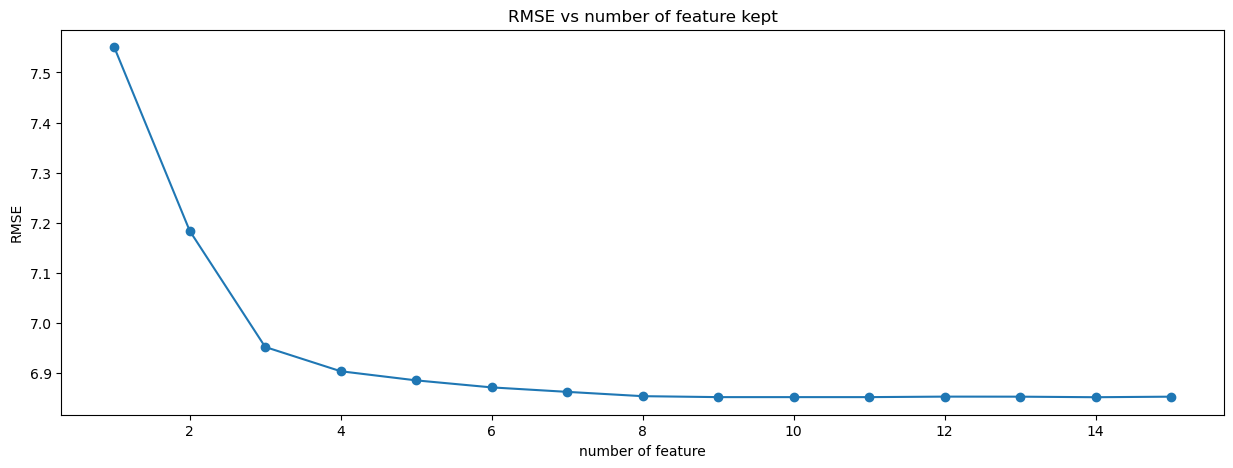

In [67]:
plt.figure(figsize=(15,5))
plt.plot([i for i in range(1,len(cv_error_list_rt)+1)], cv_error_list_rt, marker='o')
plt.title("RMSE vs number of feature kept")
plt.xlabel("number of feature")
plt.ylabel("RMSE")
plt.show()

Based on the graph above, we decide to keep the first 14 principal components. Moreover, since we performed a PCA, direct interpretation of the **features** becomes more challenging.

In [68]:
selected_rt_freemoves = selected_rt[:14]
print(f"after feature selection , our RMSE is {cv_error_list_rt[13]}")

after feature selection , our RMSE is 6.8523


### final pipline

After **feature selection**, here are the RMSE values obtained for our Ridge model and our regression tree.  
(Note that we are not comparing with the Random Forest here, since **feature selection** was not applied to that model.)

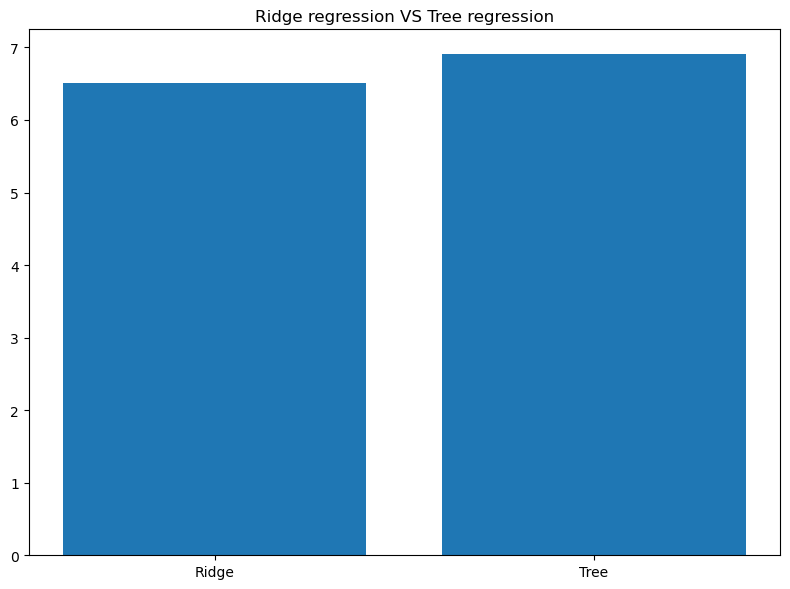

In [69]:
plt.figure(figsize=(8,6))
plt.title("Ridge regression VS Tree regression")
plt.bar(range(2), [cv_error_list_ridge[25],cv_error_list_rt[3]], align='center')
plt.xticks(range(2), ["Ridge" , "Tree"], rotation=0)
plt.tight_layout()
plt.show()

Here we see that, unlike in the **Guided** case, it is Ridge that performs better and achieves a lower RMSE.

In the following code, we define the **feature selection** for our regression tree in order to build our final pipeline.

In [70]:
def selection_feature_ridge_freemoves(k = 26):
    selected_rt = []
    n_features_to_select = k
    n_features = X_reg_pca_freemoves.shape[1] 

    kf = KFold(n_splits=5, shuffle=False)


    for round_i in tqdm(range(n_features_to_select)):
        candidates = list(set(range(n_features)) - set(selected_rt))
        cv_errors = []

        for c in candidates:
            features_to_include = selected_rt + [c]
            fold_errors = []

            for train_index, test_index in kf.split( X_reg_pca_freemoves):
                X_train =  X_reg_pca_freemoves[train_index][:, features_to_include]
                X_test =  X_reg_pca_freemoves[test_index][:, features_to_include]
                y_train, y_test = y_reg_freemoves[train_index], y_reg_freemoves[test_index]

                pipeline_ridge_freemoves.fit(X_train, y_train)
                y_pred = pipeline_ridge_freemoves.predict(X_test)
                fold_errors.append(root_mean_squared_error(y_test, y_pred))

            cv_errors.append(np.mean(fold_errors))

        best_candidate = candidates[np.argmin(cv_errors)]
        selected_rt.append(best_candidate)
        

    return(selected_rt)

Finally, we create a scikit-learn Pipeline that integrates own custom feature extraction class, the optimal feature selection step, and the best-performing regression model identified from your cross-validation results. We also include the preliminary PCA performed on the data.

In [71]:
pipeline_final_freemoves = Pipeline([
    ("feature extraction", Transformer()),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("pre feature selection", pca_freemoves),
    ("feature selection",selection_feature_ridge_freemoves(k = 26)),
    ("regressor", Ridge(alpha = 200, random_state=42))
])

100%|██████████| 26/26 [00:34<00:00,  1.32s/it]


### Neural Network and Riemanian approach

As in the **Guided** section, we will implement a Ridge and a Random Forest using a Riemannian approach.

In [72]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace


kf = KFold(n_splits=5, shuffle=False)

pipeline_ridge_2 = Pipeline([
("matrix_cov", Covariances(estimator="oas")),
("tangent_space", TangentSpace()),
("scaler", StandardScaler()),
("regressor", Ridge(alpha = 1, random_state=42))
])
rmse_score_ridge_2=[]
nmse_score_ridge_2 = []
for train_id, val_id in kf.split(window_X_freemoves):
    X_train, X_test = window_X_freemoves[train_id],window_X_freemoves[val_id]
    y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]
    pipeline_ridge_2.fit(X_train,y_train)
    y_pred_pipe_3 = pipeline_ridge_2.predict(X_test)
    rmse_pipeline_ridge_2 = root_mean_squared_error(y_test, y_pred_pipe_3)
    rmse_score_ridge_2.append(rmse_pipeline_ridge_2)
    mse_pipeline_ridge_2  = mean_squared_error(y_test,y_pred_pipe_3)
    nmse_score_ridge_2.append(mse_pipeline_ridge_2/np.var(y_test))

    
print("Pipeline (Ridge) RMSE: ",np.mean(rmse_score_ridge_2))
print("Pipeline (Ridge) NMSE: ",np.mean(nmse_score_ridge_2))


###RANDOM FOREST

pipeline_rf_2 = Pipeline([
("matrix_cov", Covariances(estimator="oas")),
("tangent_space", TangentSpace()),
("scaler", StandardScaler()),
("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])
rmse_score_rf_2=[]
nmse_score_rf_2 = []
for train_id, val_id in kf.split(window_X_freemoves):
    X_train, X_test = window_X_freemoves[train_id],window_X_freemoves[val_id]
    y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]
    pipeline_rf_2.fit(X_train,y_train)
    y_pred_pipe_4 = pipeline_rf_2.predict(X_test)
    rmse_pipeline_rf_2 = root_mean_squared_error(y_test, y_pred_pipe_4)
    rmse_score_rf_2.append(rmse_pipeline_rf_2)
    mse_pipeline_rf_2  = mean_squared_error(y_test,y_pred_pipe_4)
    nmse_score_rf_2.append(mse_pipeline_rf_2/np.var(y_test))

    
print("Pipeline (Random Forest) RMSE: ",np.mean(rmse_score_rf_2))
print("Pipeline (Random Forest) NMSE: ",np.mean(nmse_score_rf_2))

Pipeline (Ridge) RMSE:  6.388504644358766
Pipeline (Ridge) NMSE:  0.19409753430626614
Pipeline (Random Forest) RMSE:  6.472259719768063
Pipeline (Random Forest) NMSE:  0.19666354684356854


As in the **Guided** section, we will implement a Neural Network in the same way.

In [73]:
kf = KFold(n_splits=5, shuffle=False)

class Simple3LayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)  # ReLU activation
        x = self.fc2(x)    # linear output for regression
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        return x
    
def RMSE(a, b):
    return torch.sqrt(torch.mean((a-b)**2))

input_dim = 72
hidden_dim = 64 #adjustable
output_dim = 51
eta = 1e-3 #adjustable
epoch = 150 #adjustable
batch_size = 64 #adjustable
rmse_neural = []
early_stopping = 15 #adjustable 
no_improvement = 0 
l2_regu = 1e-3 #adjustable
best_rmse = 20.0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg_freemoves)
X_nn = torch.tensor(X_scaled, dtype=torch.float32)
y_nn = torch.tensor(y_data_preparation(y,window_size = 500,overlap = 0.5), dtype=torch.float32)

for train_id, val_id in kf.split(X_nn):
    X_train, X_test = X_nn[train_id], X_nn[val_id]
    y_train, y_test = y_nn[train_id], y_nn[val_id]
    model = Simple3LayerMLP(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=eta,weight_decay=l2_regu)
    #optimizer = optim.RMSprop(model.parameters(), lr=eta)
    #entraînement
    for i in range(epoch):
        model.train()
        optimizer.zero_grad() #reset the gradient 
        for j in range(0,len(X_train),batch_size): #minibatch
            X_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]
            y_pred_train_batch = model(X_batch)
            loss = criterion(y_pred_train_batch, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 

        # Gradient descent step
        #with torch.no_grad():
            #for param in model.parameters():
                #param -= eta * param.grad
                #param.grad.zero_()
    
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            rmse = RMSE(y_pred_test,y_test)
        
        #early stopping
        if rmse < best_rmse:
            best_rmse = rmse
            no_improvement = 0
            best_model_state = model.state_dict() #save the best model
        else:
            no_improvement +=   1 
            if no_improvement >= early_stopping:
                print('no improvement of the RMSE')
                model.load_state_dict(best_model_state) #load the best model
                break

            
            
    #validation
    model_freemoves = model
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        rmse2 = RMSE(y_pred_test,y_test)
        print(rmse2)
    
        
        rmse_neural.append(rmse2.item())
        print(rmse_neural)

moyenne_rmse = np.mean(rmse_neural)
print(moyenne_rmse)

no improvement of the RMSE
tensor(10.7790)
[10.778974533081055]
no improvement of the RMSE
tensor(10.4149)
[10.778974533081055, 10.414885520935059]
no improvement of the RMSE
tensor(8.5048)
[10.778974533081055, 10.414885520935059, 8.504776954650879]
no improvement of the RMSE
tensor(7.6939)
[10.778974533081055, 10.414885520935059, 8.504776954650879, 7.693891525268555]
no improvement of the RMSE
tensor(7.2403)
[10.778974533081055, 10.414885520935059, 8.504776954650879, 7.693891525268555, 7.2403388023376465]
8.926573467254638


### Results Comparaison

This code was generated by an artificial intelligence (for the structure)

In [75]:
#This code was generated by an artificial intelligence 
model_names = [ 
    "Random Forest with PCA",
    "Ridge with PCA",
    "Ridge with PCA and comp selection",
    "Tree Regression with PCA",
    "Tree Regression with PCA and comp selection",
    "Ridge with Riemann geometry",
    "Random Forest with Riemann geometry",
    "Neural Network",
]
results_df = pd.DataFrame(columns=["RMSE", "NMSE", "Training Time"], index=model_names)
results_df.loc["Random Forest with PCA"] = [6.439, 0.196, "+/- 420s"]
results_df.loc["Ridge with PCA"] = [6.595, 0.208, "less than 3s"]
results_df.loc["Ridge with PCA and comp selection"] = [6.509, "", "less than 3s"]
results_df.loc["Tree Regression with PCA"] = [7.109, 0.245, "less than 3s"]
results_df.loc["Tree Regression with PCA and comp selection"] = [6.853, "", "less than 3s"]
results_df.loc["Ridge with Riemann geometry"] = [6.388, 0.194, "less than 3s"]
results_df.loc["Random Forest with Riemann geometry"] = [6.472, 0.197, "+/- 420s"]
results_df.loc["Neural Network"] = ["+/- 8.9", "", "+/- 20s"]
print(results_df)

                                                RMSE   NMSE Training Time
Random Forest with PCA                         6.439  0.196      +/- 420s
Ridge with PCA                                 6.595  0.208  less than 3s
Ridge with PCA and comp selection              6.509         less than 3s
Tree Regression with PCA                       7.109  0.245  less than 3s
Tree Regression with PCA and comp selection    6.853         less than 3s
Ridge with Riemann geometry                    6.388  0.194  less than 3s
Random Forest with Riemann geometry            6.472  0.197      +/- 420s
Neural Network                               +/- 8.9              +/- 20s


### exercice 6 freemoves

Following the **feature selection** obtained during the Baseline approach, we define new datasets for each of our models to keep the principal components selected during **feature selection**.

In [76]:
X_reg_rf_freemoves =  X_reg_pca_freemoves
X_reg_ridge_freemoves =  X_reg_pca_freemoves[:,selected_ridge_freemoves] # We keep only the features selected during the feature selection step in the Baseline approach
X_reg_rt_freemoves =  X_reg_pca_freemoves [:, selected_rt_freemoves]

We implement an assembling strategy by averaging the predictions of the models built in the Baseline approach.
We will then calculate its RMSE in order to compare it with the RMSEs of the three models from our Baseline approach.

In [77]:
kf = KFold(n_splits=5, shuffle=False)
rmse_score_average = []
nmse_score_average = []

for train_id, val_id in kf.split(X_reg_pca_freemoves):
    X_test = X_reg_pca_freemoves[val_id]
    y_train, y_test = y_reg_freemoves[train_id], y_reg_freemoves[val_id]
    ### Random forest
    X_train_rf = X_reg_rf_freemoves[train_id]
    pipeline_rf.fit(X_train_rf, y_train)
    y_1 = pipeline_rf.predict(X_test)
    ### Ridge regression
    X_train_ridge = X_reg_ridge_freemoves[train_id]
    pipeline_ridge_freemoves.fit(X_train_ridge, y_train)
    y_2 = pipeline_ridge_freemoves.predict(X_test[:,selected_ridge_freemoves])
    ### Regression Tree
    X_train_rt = X_reg_rt_freemoves[train_id]
    pipeline_rt_freemoves.fit(X_train_rt, y_train)
    y_3 = pipeline_rt_freemoves.predict(X_test[:,selected_rt_freemoves])
    ### Average
    y_final = (y_1 + y_2 + y_3 )/3
    
    rmse_pipeline_rt = root_mean_squared_error(y_test, y_final)
    mse_pipeline_rt  = mean_squared_error(y_test,y_final)

    rmse_score_average.append(rmse_pipeline_rt)
    nmse_score_average.append(mse_pipeline_rt/np.var(y_test))

    

print("Pipeline (Average) RMSE: ",np.mean(rmse_score_average))
print("Pipeline (Average) NMSE: ",np.mean(nmse_score_average))

Pipeline (Average) RMSE:  6.289501860468676
Pipeline (Average) NMSE:  0.18678949170121584


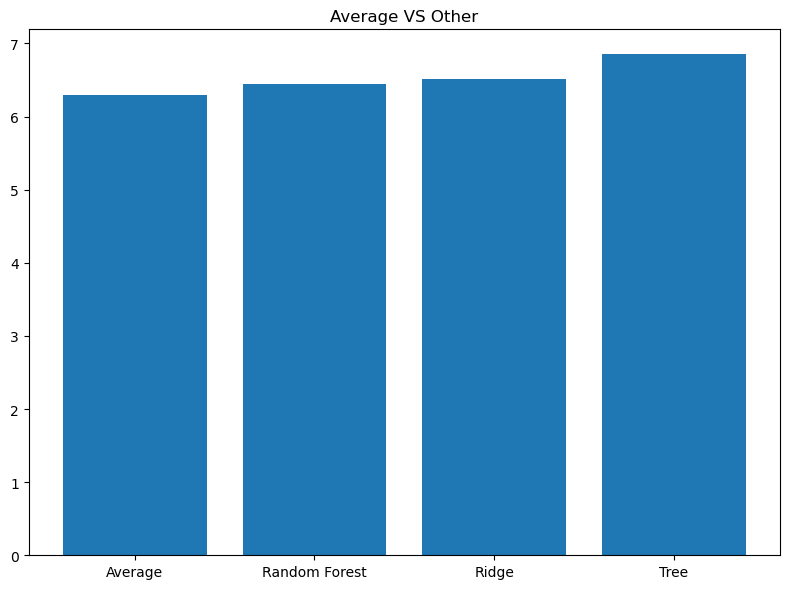

In [78]:
plt.figure(figsize=(8,6))
plt.title("Average VS Other")
plt.bar(range(4), [6.29,6.44,6.52,6.85], align='center')
plt.xticks(range(4), ["Average","Random Forest","Ridge" , "Tree"], rotation=0)
plt.tight_layout()
plt.show()

We observe that our RMSE is lower than those of the Random Forest, Ridge, and Regression Tree models (6.44, 6.52, and 6.85 respectively).
The explanation is the same as in the **Guided** section.

**meta learner**

In [79]:
pipeline_ridge_meta = Pipeline([
("imputer", SimpleImputer(strategy="mean")),
("scaler", StandardScaler()),
("regressor", Ridge(alpha = 1, random_state=42))
])

pipeline_rf_meta = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators= 10, random_state=42))
])

rmse_score_meta = []
nmse_score_meta = []
liste_coef_importance =[]
rmse_score_meta_on_train = []

kf_meta = KFold(n_splits=5, shuffle=False)
kf_model = KFold(n_splits=4, shuffle=False)

for train_id_meta, val_id_meta in kf_meta.split(X_reg_pca_freemoves):
    X_train_meta, X_test_meta = X_reg_pca_freemoves[train_id_meta], X_reg_pca_freemoves[val_id_meta]
    y_train_meta, y_test_meta = y_reg_freemoves[train_id_meta], y_reg_freemoves[val_id_meta]
    
    liste_y_pred_rf = []
    liste_y_pred_ridge = []
    liste_y_pred_rt = []

    for train_id_model, val_id_model in kf_model.split(X_train_meta):
        X_train_model, X_test_model = X_reg_pca_freemoves[train_id_model], X_reg_pca_freemoves[val_id_model]
        y_train_model, y_test_model = y_reg_freemoves[train_id_model], y_reg_freemoves[val_id_model]        

        ### Random forest
        X_train_rf = X_reg_rf_freemoves[train_id_model]
        pipeline_rf_meta.fit(X_train_rf, y_train_model)
        liste_y_pred_rf.append(pipeline_rf_meta.predict(X_test_model))
        
        ### Ridge regression
        X_train_ridge, X_test_ridge = X_reg_ridge_freemoves[train_id_model], X_reg_ridge_freemoves[val_id_model]
        pipeline_ridge_freemoves.fit(X_train_ridge, y_train_model)
        liste_y_pred_ridge.append(pipeline_ridge_freemoves.predict(X_test_ridge))
        
        ### Regression Tree
        X_train_rt, X_test_rt = X_reg_rt_freemoves[train_id_model], X_reg_rt_freemoves[val_id_model]
        pipeline_rt_freemoves.fit(X_train_rt, y_train_model)
        liste_y_pred_rt.append(pipeline_rt_freemoves.predict(X_test_rt))

    
    y_pred_ridge = np.concatenate(liste_y_pred_ridge, axis=0)
    y_pred_rt = np.concatenate(liste_y_pred_rt, axis=0)
    y_pred_rf = np.concatenate(liste_y_pred_rf, axis=0)

    y_for_meta = [y_pred_ridge, y_pred_rt, y_pred_rf]
    X_new_train_meta = np.concatenate(y_for_meta, axis=1)


    #### We will now focus on the meta test phase  
    pipeline_rf_meta.fit(X_train_meta, y_train_meta)
    y_pred_pipe_rf = pipeline_rf_meta.predict(X_test_meta)
    
    pipeline_ridge_freemoves.fit(X_train_meta, y_train_meta)
    y_pred_pipe_ridge = pipeline_ridge_freemoves.predict(X_test_meta)
    
    pipeline_rt_freemoves.fit(X_train_meta, y_train_meta)
    y_pred_pipe_rt = pipeline_rt_freemoves.predict(X_test_meta)
    
    y_test_for_meta = [y_pred_pipe_ridge, y_pred_pipe_rt, y_pred_pipe_rf]
    
    
    pipeline_ridge_meta.fit(X_new_train_meta, y_train_meta)
    y_pred_pipe_train = pipeline_ridge_meta.predict(X_new_train_meta)
    rmse_score_meta_on_train.append(root_mean_squared_error(y_train_meta, y_pred_pipe_train))
    y_pred_pipe = pipeline_ridge_meta.predict(np.concatenate(y_test_for_meta, axis=1))
    


    rmse_pipeline_meta = root_mean_squared_error(y_test_meta, y_pred_pipe)
    mse_pipeline_meta  = mean_squared_error(y_test_meta,y_pred_pipe)


    rmse_score_meta.append(rmse_pipeline_meta)
    nmse_score_meta.append(mse_pipeline_meta/np.var(y_test_meta))
    
    
    #feature importance     
    coef_importances = pipeline_ridge_meta.named_steps["regressor"].coef_
    coefs_per_model = np.split(coef_importances, 3)
    for all_coefs_for_a_model in coefs_per_model:
        liste_coef_importance.append(np.linalg.norm(all_coefs_for_a_model))


model_importance = []
for i in range(3):  
    model_importance.append(sum(liste_coef_importance[i::3]) / len(liste_coef_importance[i::3]))

relative_importance = []
somme = sum(model_importance)
for i in model_importance:
    relative_importance.append(round(100 * i / somme, 1))
    
print(relative_importance)
print("Pipeline (Meta Learner) RMSE: ",np.mean(rmse_score_meta))
print("Pipeline (Meta Learner) NMSE: ",np.mean(nmse_score_meta))
print("tradeoff biais-variance RMSE: ",np.mean(np.array(rmse_score_meta_on_train) - np.array(rmse_score_meta)))

[np.float64(20.2), np.float64(40.4), np.float64(39.5)]
Pipeline (Meta Learner) RMSE:  8.002202529023911
Pipeline (Meta Learner) NMSE:  0.3147152563326538
tradeoff biais-variance NMSE:  -1.4906416056089913


The interpretations are the same as in **Guided**

Here as well, our **Average** gives a better RMSE than our **Meta-learner strategy**.

### Definition of the different prediction functions

In this section, we will define the various functions useful for making predictions with the different models described above.

**Random Forest + Ridge + Regression Tree**

In [81]:
def prediction_tot_model_freemoves(X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the different predicted y values for each of these windows using the 3 modele describe in the section Baseline approach. (one prediction for each model)

    """
    
    kf = KFold(n_splits=5, shuffle=False)
    liste_y_pred_rf = []
    liste_y_pred_ridge = []
    liste_y_pred_rt = []

    for train_id, val_id in kf.split(X_reg_pca_freemoves):
        y_train = y_reg_freemoves[train_id]
        ### Random forest
        X_train_rf = X_reg_rf_freemoves[train_id]
        pipeline_rf.fit(X_train_rf, y_train)
        liste_y_pred_rf.append(pipeline_rf.predict(X_test))
        ### Ridge regression
        X_train_ridge = X_reg_ridge_freemoves[train_id]
        pipeline_ridge_freemoves.fit(X_train_ridge, y_train)
        liste_y_pred_ridge.append(pipeline_ridge_freemoves.predict(X_test[:,selected_ridge_freemoves]))
        ### Regression Tree
        X_train_rt = X_reg_rt_freemoves[train_id]
        pipeline_rt_freemoves.fit(X_train_rt, y_train)
        liste_y_pred_rt.append(pipeline_rt_freemoves.predict(X_test[:,selected_rt_freemoves]))

    y_pred_rf = np.mean( liste_y_pred_rf, axis=0)
    y_pred_ridge = np.mean( liste_y_pred_ridge, axis=0)
    y_pred_rt = np.mean( liste_y_pred_rt, axis=0)

    return [ y_pred_rf, y_pred_ridge , y_pred_rt]

**Riemannian Geometry-Based Approach**

In [82]:
def prediction_riemannian_model_freemoves (X_test):
    """
    Takes as input an X_test with shape (a, b, c), where a = the number of windows, b = the number of electrodes (8 here), and c = the window size (500 here).
    It returns a list of 2 elements containing, in order, our Riemannian Ridge prediction followed by our Riemannian Random Forest prediction.
    """

    kf = KFold(n_splits=5, shuffle=False)

    pipeline_ridge_2 = Pipeline([
    ("matrix_cov", Covariances(estimator="oas")),
    ("tangent_space", TangentSpace()),
    ("scaler", StandardScaler()),
    ("regressor", Ridge(alpha = 1, random_state=42))
    ])
    liste_y_pred_riemannian_ridge =[]

    for train_id, val_id in kf.split(window_X_freemoves):
        X_train = window_X_freemoves[train_id]
        y_train = y_reg_freemoves[train_id]
        pipeline_ridge_2.fit(X_train,y_train)
        y_pred_pipe_3 = pipeline_ridge_2.predict(X_test)
        liste_y_pred_riemannian_ridge.append(y_pred_pipe_3)

    y_pred_riemannian_ridge_freemoves = np.mean(liste_y_pred_riemannian_ridge , axis = 0)


    pipeline_rf_2 = Pipeline([
    ("matrix_cov", Covariances(estimator="oas")),
    ("tangent_space", TangentSpace()),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    liste_y_pred_riemannian_rf =[]
    
    for train_id, val_id in kf.split(window_X_freemoves):
        X_train = window_X_freemoves[train_id]
        y_train = y_reg_freemoves[train_id]
        pipeline_rf_2.fit(X_train,y_train)
        y_pred_pipe_4 = pipeline_rf_2.predict(X_test)
        liste_y_pred_riemannian_rf.append(y_pred_pipe_4)

    y_pred_riemannian_rf_freemoves = np.mean(liste_y_pred_riemannian_rf , axis = 0)

    return [y_pred_riemannian_ridge_freemoves , y_pred_riemannian_rf_freemoves ]

**Neural Network**

In [83]:
def predict_NN_freemoves (X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the estimated y using a neural network
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reg_freemoves)


    model_freemoves.eval()
    with torch.no_grad():
        y_pred_NN_freemoves = model_freemoves(torch.tensor(scaler.transform(X_test),dtype=torch.float32)).numpy()
    return y_pred_NN_freemoves

**Average Model**

In [84]:
def prediction_average_model_freemoves(X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the different predicted y values for each of these windows using the average of the 3 modele describe in the section Baseline approach

    """

    kf = KFold(n_splits=5, shuffle=False)
    liste_y_pred_rf = []
    liste_y_pred_ridge = []
    liste_y_pred_rt = []

    for train_id, val_id in kf.split( X_reg_pca_freemoves):
        y_train = y_reg_freemoves[train_id]
        ### Random forest
        X_train_rf = X_reg_rf_freemoves[train_id]
        pipeline_rf.fit(X_train_rf, y_train)
        liste_y_pred_rf.append(pipeline_rf.predict(X_test))
        ### Ridge regression
        X_train_ridge = X_reg_ridge_freemoves[train_id]
        pipeline_ridge_freemoves.fit(X_train_ridge, y_train)
        liste_y_pred_ridge.append(pipeline_ridge_freemoves.predict(X_test[:,selected_ridge_freemoves]))
        ### Regression Tree
        X_train_rt = X_reg_rt_freemoves[train_id]
        pipeline_rt_freemoves.fit(X_train_rt, y_train)
        liste_y_pred_rt.append(pipeline_rt_freemoves.predict(X_test[:,selected_rt_freemoves]))

    y_pred_rf = np.mean( liste_y_pred_rf, axis=0)
    y_pred_ridge = np.mean( liste_y_pred_ridge, axis=0)
    y_pred_rt = np.mean( liste_y_pred_rt, axis=0)

    y_pred = (y_pred_rf + y_pred_ridge + y_pred_rt)/3

    return (y_pred)

**Meta-learner Strategy**

In [99]:
def predict_meta_learner_freemoves (X_test):
    """
    Function that receives as an argument an array of size (a, b), where a represents the number of windows and b the dimension of each window.
    The function returns the estimated y using a meta-learner strategy
    """

    pipeline_ridge_meta = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha = 1, random_state=42))
    ])

    pipeline_rf_meta = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor(n_estimators= 10, random_state=42))
    ])

    liste_pred_meta = []

    kf_meta = KFold(n_splits=5, shuffle=False)
    kf_model = KFold(n_splits=4, shuffle=False)

    for train_id_meta, val_id_meta in kf_meta.split(X_reg_pca_freemoves):
        X_train_meta, X_test_meta = X_reg_pca_freemoves[train_id_meta], X_test
        y_train_meta = y_reg_freemoves[train_id_meta]
    
        liste_y_pred_rf = []
        liste_y_pred_ridge = []
        liste_y_pred_rt = []

        for train_id_model, val_id_model in kf_model.split(X_train_meta):
            X_train_model, X_test_model = X_reg_pca_freemoves[train_id_model], X_reg_pca_freemoves[val_id_model]
            y_train_model, y_test_model = y_reg_freemoves[train_id_model], y_reg_freemoves[val_id_model]        

            ### Random forest
            X_train_rf = X_reg_rf_freemoves[train_id_model]
            pipeline_rf_meta.fit(X_train_rf, y_train_model)
            liste_y_pred_rf.append(pipeline_rf_meta.predict(X_test_model))
        
            ### Ridge regression
            X_train_ridge, X_test_ridge = X_reg_ridge_freemoves[train_id_model], X_reg_ridge_freemoves[val_id_model]
            pipeline_ridge_freemoves.fit(X_train_ridge, y_train_model)
            liste_y_pred_ridge.append(pipeline_ridge_freemoves.predict(X_test_ridge))
        
            ### Regression Tree
            X_train_rt, X_test_rt = X_reg_rt_freemoves[train_id_model], X_reg_rt_freemoves[val_id_model]
            pipeline_rt_freemoves.fit(X_train_rt, y_train_model)
            liste_y_pred_rt.append(pipeline_rt_freemoves.predict(X_test_rt))

    
        y_pred_ridge = np.concatenate(liste_y_pred_ridge, axis=0)
        y_pred_rt = np.concatenate(liste_y_pred_rt, axis=0)
        y_pred_rf = np.concatenate(liste_y_pred_rf, axis=0)

        y_for_meta = [y_pred_ridge, y_pred_rt, y_pred_rf]
        X_new_train_meta = np.concatenate(y_for_meta, axis=1)


        #### We will now focus on the meta test phase
        pipeline_rf_meta.fit(X_train_meta, y_train_meta)
        y_pred_pipe_rf = pipeline_rf_meta.predict(X_test_meta)
    
        pipeline_ridge_freemoves.fit(X_train_meta, y_train_meta)
        y_pred_pipe_ridge = pipeline_ridge_freemoves.predict(X_test_meta)
    
        pipeline_rt_freemoves.fit(X_train_meta, y_train_meta)
        y_pred_pipe_rt = pipeline_rt_freemoves.predict(X_test_meta)
    
        y_test_for_meta = [y_pred_pipe_ridge, y_pred_pipe_rt, y_pred_pipe_rf]
    
    
        pipeline_ridge_meta.fit(X_new_train_meta, y_train_meta)
        y_pred_pipe = pipeline_ridge_meta.predict(np.concatenate(y_test_for_meta, axis=1))

        liste_pred_meta.append(y_pred_pipe)


    return np.mean(liste_pred_meta, axis = 0)

## Exo 7

**Guided Dataset**

In the **Guided part**, our 3 best models in terms of RMSE are the **Random Forest** using a **Riemannian approach**, a classic **Random Forest**, and the **Average** of the 3 models from the Baseline approach. However, when we take the average of these three as the prediction, we get a worse RMSE on the site than by using only the **Average**. Therefore, we decided to implement an **Average**
that gives us the best RMSE on the site.

First, we will load our data and reshape it to the correct dimensions so that we can work with it.

In [86]:
X_testset_guided = guided_testset_X # shape (5 , 332 , 8 , 500)
X_test_riemannian_guided = X_testset_guided.reshape(-1, X_testset_guided.shape[2], X_testset_guided.shape[3]) # shape (1660 , 8 , 500)
X_test_guided = Transformer().transform(X_testset_guided.reshape(-1, X_testset_guided.shape[2], X_testset_guided.shape[3])) # shape (1660 , 8 * nb_feature)

Here, we will predict our X_test_guided using the **Average** model.

In [87]:
y_pred_average_guided = prediction_average_model_guided(pca_guided.transform(X_test_guided))
print(y_pred_average_guided)

[[ 41.03736415 -64.32178767 -31.08763487 ...  -1.89414128  -4.7893493
  -48.34458131]
 [ 40.51486062 -64.05890566 -29.42791464 ...  -1.73338226  -4.87209842
  -44.28715278]
 [ 39.68319753 -63.52138816 -26.61247725 ...  -1.74501902  -4.83703634
  -44.93262826]
 ...
 [ 34.35816178 -61.8739436  -10.99072345 ...  -0.61556335  -5.42556098
  -16.3821862 ]
 [ 35.11181769 -62.0022895  -13.11585882 ...  -0.64170789  -5.40398189
  -17.11986124]
 [ 36.21199936 -62.35620873 -16.34100998 ...  -0.86462123  -5.29762512
  -22.63809842]]


Here, we will provide all the lines of code needed to predict X_test_guided using the other models presented in this report.

```python

# returns the predictions as a list of, respectively, rf, ridge and rt 
y_pred_tot_guided = prediction_tot_model_guided(pca_guided.transform(X_test_guided))
print(y_pred_tot_guided)

# returns the predictions as a list of, respectively, ridge riemannian and RF riemannian
y_pred_riemannian_guided = prediction_riemannian_model_guided(X_test_riemannian_guided)
print(y_pred_riemannian_guided)

# returns Neural Network
y_pred_NN_guided = predict_NN_guided(X_test_guided)
print(y_pred_NN_guided)

# returns the prediction obtained via averaging
y_pred_average_guided = prediction_average_model_guided(pca_guided.transform(X_test_guided))
print(y_pred_average_guided)

# returns the prediction obtained via the meta-learner
y_pred_meta_learner_guided = predict_meta_learner_guided(pca_guided.transform(X_test_guided))
print(y_pred_meta_learner_guided)

**Freemoves Dataset**

We noticed that for the freemoves dataset, it is the average of the 3 models from the **Baseline approach** (the **Average model**) that gives us the best RMSE, followed by **Ridge** using a **Riemannian approach**. We therefore decided (given the independence of the models) to take as the prediction for the **Freemoves part** an average of these 2 models.

First, we will load our data and reshape it to the correct dimensions so that we can work with it.

In [88]:
X_testset_freemoves = freemoves_testset_X # shape (5 , 308 , 8 , 500)
X_test_riemannian_freemoves = X_testset_freemoves.reshape(-1, X_testset_freemoves.shape[2], X_testset_freemoves.shape[3]) # shape (1540 , 8 , 500)
X_test_freemoves = Transformer().transform(X_testset_freemoves.reshape(-1, X_testset_freemoves.shape[2], X_testset_freemoves.shape[3])) # shape (1540 , 8 * nb_feature)

Here, we will predict our X_test_freemoves using the **Average** model

In [89]:
y_pred_average_freemoves = prediction_average_model_freemoves(pca_freemoves.transform(X_test_freemoves))
print(y_pred_average_freemoves)

[[ 39.71608624 -63.87929506 -27.22902276 ...  -0.71884662  -5.41508396
  -18.77852742]
 [ 39.66237417 -63.82217199 -27.00731042 ...  -0.66518835  -5.45377091
  -17.26854304]
 [ 39.64124502 -63.82604224 -26.97227122 ...  -0.62401726  -5.46710883
  -16.30520777]
 ...
 [ 38.93855255 -63.5047816  -24.81376862 ...  -1.16646439  -5.12600659
  -30.76982932]
 [ 38.33445435 -63.26853293 -22.98272058 ...  -1.14660347  -5.14155284
  -30.20743781]
 [ 38.65532559 -63.47703899 -24.06967739 ...  -1.22124591  -5.0720393
  -32.47328658]]


Here, we will predict our X_test_freemoves using the **Ridge Riemannian** model.

In [90]:
y_pred_ridge_riemannian_freemoves = prediction_riemannian_model_freemoves(X_test_riemannian_freemoves)[0]
print(y_pred_ridge_riemannian_freemoves)

[[ 41.97048852 -64.77088328 -34.12237041 ...  -0.81187544  -5.32250891
  -21.57719708]
 [ 41.10768009 -64.30860103 -31.31129361 ...  -0.67369918  -5.39753773
  -18.03550976]
 [ 39.95307265 -63.80209471 -27.71682409 ...  -0.56608619  -5.46627225
  -15.15406253]
 ...
 [ 40.16890351 -64.16917525 -28.90723797 ...  -0.56908118  -5.52529783
  -14.34036794]
 [ 39.17991963 -63.65152471 -25.67711968 ...  -1.15462913  -5.20486141
  -29.42174397]
 [ 38.47431014 -63.27224728 -23.33782531 ...  -1.17511052  -5.15159683
  -30.46854548]]


Here, we will provide all the lines of code needed to predict X_test_freemoves using the other models presented in this report.

```python

# returns the predictions as a list, in order, rf, ridge and rt
y_pred_tot_freemoves = prediction_tot_model_freemoves(pca_freemoves.transform(X_test_freemoves))
print(y_pred_tot_freemoves)

# returns the predictions as a list, in order, ridge riemannian and RF riemannian
y_pred_riemannian_freemoves = prediction_riemannian_model_freemoves(X_test_riemannian_freemoves)
print(y_pred_riemannian_freemoves)

# returns Neural Network
y_pred_NN_freemoves = predict_NN_freemoves(X_test_freemoves)
print(y_pred_NN_freemoves)

# returns the prediction obtained via averaging
y_pred_average_freemoves = prediction_average_model_freemoves(pca_freemoves.transform(X_test_freemoves))
print(y_pred_average_freemoves)

# returns the prediction obtained via the meta-learner
y_pred_meta_learner_freemoves = predict_meta_learner_freemoves(pca_freemoves.transform(X_test_freemoves))
print(y_pred_meta_learner_freemoves)

**Assembling Guided and Freemoves for to have ONE prediction**

In [117]:
y_pred_guided = y_pred_average_guided # To modify if we want to test other models.
y_pred_freemoves = (y_pred_average_freemoves + y_pred_ridge_riemannian_freemoves)/2  # To modify if we want to test other models.
res = np.vstack((y_pred_guided,y_pred_freemoves))
df = pd.DataFrame(res)
df.to_csv('team_submission.csv', index=False, header=False)

We tested our result on the competition website and obtained an RMSE of 9.9036.

## Conclusion

To conclude this project, we used several regression models, including Ridge, Random Forest, and Regression Tree, as well as more sophisticated methods such as a Neural Network and a pipeline using the Riemannian approach, to predict hand angles from EMG signals.
We discussed the performance of each model and, by the end of the project, selected a model or set of models for each protocol (Guided and Freemoves).
Based on our analysis, Freemove gestures are more difficult to predict than Guided gestures. This is due to the greater complexity of the movements in the Freemove part compared to the Guided part, where only 5 different movements are repeated.

## Bibliography

- A Comprehensive Study on EMG Feature Extraction and Classifiers (https://lupinepublishers.com/biomedical-sciences-journal/fulltext/a-comprehensive-study-on-eMG-feature-extraction-and-classifiers.ID.000104.php)
- EMG-Based Feature Extraction and Classification for Prosthetic Hand Control (https://arxiv.org/abs/2107.00733)
- 15 ways to optimize  your neural network training (https://www.dailydoseofds.com/15-ways-to-optimize-neural-network-training-with-implementation/)
- Optimizing Neural Networks: Key Techniques to Boost Performance and Generalization(https://medium.com/@lmpo/key-techniques-for-improved-neural-network-training-a515d8be01ba)